## Algerian Forest Fires Dataset 
Data Set Information:

The dataset includes 244 instances that regroup a data of two regions of Algeria,namely the Bejaia region located in the northeast of Algeria and the Sidi Bel-abbes region located in the northwest of Algeria.

122 instances for each region.

The period from June 2012 to September 2012.
The dataset includes 11 attribues and 1 output attribue (class)
The 244 instances have been classified into fire(138 classes) and not fire (106 classes) classes.

---

Attribute Information:

1. Date : (DD/MM/YYYY) Day, month ('june' to 'september'), year (2012)
Weather data observations
2. Temp : temperature noon (temperature max) in Celsius degrees: 22 to 42
3. RH : Relative Humidity in %: 21 to 90
4. Ws :Wind speed in km/h: 6 to 29
5. Rain: total day in mm: 0 to 16.8
FWI Components
6. Fine Fuel Moisture Code (FFMC) index from the FWI system: 28.6 to 92.5
7. Duff Moisture Code (DMC) index from the FWI system: 1.1 to 65.9
8. Drought Code (DC) index from the FWI system: 7 to 220.4
9. Initial Spread Index (ISI) index from the FWI system: 0 to 18.5
10. Buildup Index (BUI) index from the FWI system: 1.1 to 68
11. Fire Weather Index (FWI) Index: 0 to 31.1
12. Classes: two classes, namely Fire and not Fire

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the Algerian Forest Fires dataset.
# ---------------------------------------------------------------
# The CSV file contains two datasets (Bejaia & Sidi Bel-Abbès) in a
# single file, separated by blank rows and a repeated header row.
#
# `skipinitialspace=True` → removes unwanted spaces that appear after commas
# `header=1` → skips the first row in the CSV because the file begins with a
#              title row and the actual table column names start on line 2.
# ---------------------------------------------------------------
dataset = pd.read_csv(
    'Algerian_forest_fires_dataset_UPDATE.csv',
    skipinitialspace=True,
    header=1
)

# Find where the repeated header row appears
split_index = dataset[dataset['day'] == 'day'].index[0]

# Remove the repeated column header present in the middle of the dataset.
# ---------------------------------------------------------------
# When merging both regional datasets into one CSV, the dataset includes
# the header row ("day, month, year, Temperature, RH, …") again halfway
# through the file.
#
# Without this filter, that repeated header stays as a normal row, which
# later breaks:
#   - statistical calculations (mean, std, correlation, etc.)
#   - numeric conversions
#   - ML model training
# So we filter out the row where column "day" contains the literal string "day".
# ---------------------------------------------------------------
dataset = dataset[dataset['day'] != 'day']

# Reset index after removing the internal header row.
# ---------------------------------------------------------------
# The previous filtering step removes one row from the middle of the
# DataFrame, leaving index values discontinuous (e.g., 0, 1, 2, 4, 5, 6, …).
#
# `reset_index(drop=True)` rebuilds a clean continuous index:
#   0, 1, 2, 3, 4, 5, …
#
# This avoids confusion during EDA, plotting, and train/test splitting,
# where continuous indexing is beneficial.
# ---------------------------------------------------------------
dataset.reset_index(drop=True, inplace=True)

display(dataset.head())
dataset.shape


,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire


(245, 14)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   day          245 non-null    object
 1   month        244 non-null    object
 2   year         244 non-null    object
 3   Temperature  244 non-null    object
 4   RH           244 non-null    object
 5   Ws           244 non-null    object
 6   Rain         244 non-null    object
 7   FFMC         244 non-null    object
 8   DMC          244 non-null    object
 9   DC           244 non-null    object
 10  ISI          244 non-null    object
 11  BUI          244 non-null    object
 12  FWI          244 non-null    object
 13  Classes      243 non-null    object
dtypes: object(14)
memory usage: 26.9+ KB


In [6]:
## DataCleaning
## Missing Values
dataset[dataset.isnull().any(axis=1)]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
122,Sidi-Bel Abbes Region Dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,14,07,2012,37,37,18,0.2,88.9,12.9,14.6 9,12.5,10.4,fire,NaN


The dataset is converted into two sets based on Region from 122th index, we can make a new column based on the Region

1 : "Bejaia Region Dataset"

2 : "Sidi-Bel Abbes Region Dataset"

Add new column with region

In [7]:
# Add a new column named "Region" to label each row with its corresponding geographical area.
# --------------------------------------------------------------------------------------------------
# The Algerian Forest Fires dataset actually combines two separate regional datasets in a single CSV:
#   • Region 0 → Bejaia (first part of the file)
#   • Region 1 → Sidi Bel-Abbès (second part of the file)
#
# We previously detected `split_index`, which marks the position where the second region begins
# (this is the line where the repeated header row originally appeared before cleaning).
#
# Using that split index:
#   • All rows before `split_index` belong to Region 0 (Bejaia)
#   • All rows starting from `split_index` belong to Region 1 (Sidi Bel-Abbès)
#
# The list comprehension below loops through each row index `i`:
#   - If i < split_index → assign 0
#   - Else → assign 1
#
# This avoids hard-coding row counts (e.g., 0–121 and 122–243) and keeps the logic robust even if
# the dataset size changes in future versions.
# --------------------------------------------------------------------------------------------------
dataset['Region'] = [0 if i < split_index else 1 for i in range(len(dataset))] # Assign region label (0 -> Bejaia, 1 -> Sidi Bel-Abbès)

display(dataset.head())

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire,0
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire,0
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire,0


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   day          245 non-null    object
 1   month        244 non-null    object
 2   year         244 non-null    object
 3   Temperature  244 non-null    object
 4   RH           244 non-null    object
 5   Ws           244 non-null    object
 6   Rain         244 non-null    object
 7   FFMC         244 non-null    object
 8   DMC          244 non-null    object
 9   DC           244 non-null    object
 10  ISI          244 non-null    object
 11  BUI          244 non-null    object
 12  FWI          244 non-null    object
 13  Classes      243 non-null    object
 14  Region       245 non-null    int64 
dtypes: int64(1), object(14)
memory usage: 28.8+ KB


In [9]:
dataset.isnull().sum()

day            0
month          1
year           1
Temperature    1
RH             1
Ws             1
Rain           1
FFMC           1
DMC            1
DC             1
ISI            1
BUI            1
FWI            1
Classes        2
Region         0
dtype: int64

In [10]:
## Removing the null values
dataset = dataset.dropna().reset_index(drop=True)

In [11]:
dataset.isnull().sum()

day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        0
Region         0
dtype: int64

In [12]:
display(dataset.iloc[[122]])

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
122,01,06,2012,32,71,12,0.7,57.1,2.5,8.2,0.6,2.8,0.2,not fire,1


In [13]:
dataset.columns

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  ', 'Region'],
      dtype='object')

In [14]:
# Clean column names by removing any unwanted leading and trailing spaces.
# -----------------------------------------------------------------------------------------
# Even though we used `skipinitialspace=True` while reading the CSV, that parameter only
# removes spaces that appear *after commas* in the dataset.  
#
# However, the original Algerian dataset contains column names with trailing spaces
# (for example: "Classes␣␣"), which pandas reads literally as part of the column name.
#
# If these spaces are not removed:
#   • dataset['Classes'] will FAIL because the actual column name is "Classes  "
#   • merging, selecting and renaming columns may break later
#   • ML preprocessing pipelines may not detect or match column names correctly
#
# `.str.strip()` safely removes both leading and trailing spaces from every column name,
# ensuring that all columns are clean, consistent, and accurately referenced in the code.
# -----------------------------------------------------------------------------------------
dataset.columns = dataset.columns.str.strip()
dataset.columns

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region'],
      dtype='object')

In [15]:
# Convert integer-type columns to int
# ------------------------------------------------------------------------------------------------------
# The Algerian Forest Fires dataset contains several columns that are conceptually categorical or
# always represented as whole numbers — such as day, month, year, relative humidity (RH), and wind
# speed (Ws). The "Classes" column also represents fire class labels (0 or 1), which should not be
# treated as floating-point values.
#
# When we initially read the CSV, many numeric values are parsed as strings ("object" dtype) because
# the dataset was originally split into two tables inside a single file. As a result, pandas cannot
# automatically infer consistent numeric types.
#
# We explicitly convert these columns to `int` to:
#   • ensure that values are stored as whole numbers (not floats or strings)
#   • avoid ML/data-processing errors later (e.g., comparisons and encoders expecting integer dtype)
#   • reduce memory usage
# ------------------------------------------------------------------------------------------------------
int_cols = ['day', 'month', 'year', 'RH', 'Ws']
dataset[int_cols] = dataset[int_cols].astype(int)

# Convert float-type columns to float
# ------------------------------------------------------------------------------------------------------
# The remaining numerical columns — Temperature, Rain, FFMC, DMC, DC, ISI, BUI, and FWI — contain
# decimal values in the real dataset. Therefore, converting them to `int` would incorrectly round or
# truncate measurements, leading to information loss and lower ML accuracy.
#
# We explicitly convert these columns to `float` to:
#   • preserve decimal precision
#   • support accurate statistical calculations and visualizations
#   • ensure full compatibility with regression and ML models that expect continuous numeric inputs
#
# This separation of int vs float handling makes the dataset numerically consistent and ready for
# reliable analysis and model training.

# Identify columns that are still stored as object (string) type
# ------------------------------------------------------------------------------------------------------
# After converting integer columns, some numeric measurements may still be stored as text
# because the dataset originally existed as two tables inside a single CSV.
# `select_dtypes(include='object')` collects all remaining columns that are not yet numeric.
# ------------------------------------------------------------------------------------------------------
object_cols = dataset.select_dtypes(include='object').columns.tolist()

# ------------------------------------------------------------------------------------------------------
# Exclude the categorical column ('Classes') from numeric conversion
# ------------------------------------------------------------------------------------------------------
# The 'Classes' column contains the fire label ("fire" / "not fire") and must remain categorical.
# Therefore, we remove it from the list of object columns before converting the rest to floats.
# ------------------------------------------------------------------------------------------------------
float_candidates = [col for col in object_cols if col != 'Classes']

# Convert all remaining object columns to float
# ------------------------------------------------------------------------------------------------------
# The columns selected above represent continuous meteorological measurements that contain
# decimal values. Converting them to float:
#   • preserves precision
#   • enables correct statistical analysis and visualization
#   • ensures compatibility with ML models requiring numeric features
# ------------------------------------------------------------------------------------------------------
dataset[float_candidates] = dataset[float_candidates].astype(float)

# Keep 'Classes' as categorical (string)
# ------------------------------------------------------------------------------------------------------
# No conversion is done for this column because keeping the raw labels ("fire" / "not fire")
# is useful for:
#   • better human interpretability
#   • descriptive analytics (countplots, pie charts, groupby summaries)
#   • EDA comparisons by category
#
# The conversion to numeric (0/1) will be done later only during ML model preparation,
# not during raw dataset cleaning.
# ------------------------------------------------------------------------------------------------------
dataset['Classes'] = dataset['Classes'].astype('category')

dataset.info()

print("\nSummary of datatype conversion completed successfully!")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   day          243 non-null    int64   
 1   month        243 non-null    int64   
 2   year         243 non-null    int64   
 3   Temperature  243 non-null    float64 
 4   RH           243 non-null    int64   
 5   Ws           243 non-null    int64   
 6   Rain         243 non-null    float64 
 7   FFMC         243 non-null    float64 
 8   DMC          243 non-null    float64 
 9   DC           243 non-null    float64 
 10  ISI          243 non-null    float64 
 11  BUI          243 non-null    float64 
 12  FWI          243 non-null    float64 
 13  Classes      243 non-null    category
 14  Region       243 non-null    int64   
dtypes: category(1), float64(8), int64(6)
memory usage: 27.3 KB

Summary of datatype conversion completed successfully!


In [16]:
dataset.describe()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Region
count,243.000000,243.000000,243.0,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,15.761317,7.502058,2012.0,32.152263,62.041152,15.493827,0.762963,77.842387,14.680658,49.430864,4.742387,16.690535,7.035391,0.497942
std,8.842552,1.114793,0.0,3.628039,14.828160,2.811385,2.003207,14.349641,12.393040,47.665606,4.154234,14.228421,7.440568,0.501028
min,1.000000,6.000000,2012.0,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,0.000000,0.000000
25%,8.000000,7.000000,2012.0,30.000000,52.500000,14.000000,0.000000,71.850000,5.800000,12.350000,1.400000,6.000000,0.700000,0.000000
50%,16.000000,8.000000,2012.0,32.000000,63.000000,15.000000,0.000000,83.300000,11.300000,33.100000,3.500000,12.400000,4.200000,0.000000
75%,23.000000,8.000000,2012.0,35.000000,73.500000,17.000000,0.500000,88.300000,20.800000,69.100000,7.250000,22.650000,11.450000,1.000000
max,31.000000,9.000000,2012.0,42.000000,90.000000,29.000000,16.800000,96.000000,65.900000,220.400000,19.000000,68.000000,31.100000,1.000000


In [17]:
# ------------------------------------------------------------------------------------------------------
# Save the cleaned dataset to a new CSV file
# ------------------------------------------------------------------------------------------------------
# After performing all preprocessing steps — including column name cleanup, datatype correction,
# categorical handling, and conversion of numeric features — it is important to preserve the cleaned
# version of the dataset in a separate file.
#
# Reasons for saving the cleaned dataset:
#   • Reusability: The cleaned file can be loaded directly in future notebooks or ML pipelines without
#     repeating the preprocessing steps every time, saving both time and computational effort.
#
#   • Reproducibility: Anyone working on this project (or even your future self) can start from a
#     standardized dataset rather than re-processing raw data again, ensuring consistent results
#     across experiments and model iterations.
#
#   • Version safety: The raw dataset remains untouched and archived as original reference data,
#     while the cleaned dataset serves as a structured and model-ready dataset — ideal for analysis,
#     visualization, and machine learning development.
#
#   • Production readiness: Clean datasets with correct datatypes are often required for automated
#     ML systems, pipelines, dashboards, or deployment environments.
#
# `index=False` ensures that pandas does not write row index numbers into the CSV because they are
# not part of the actual feature set and can interfere with further processing if included.
# ------------------------------------------------------------------------------------------------------
dataset.to_csv('Algerian_forest_fires_cleaned_dataset.csv', index=False)

Exploratory Data Analysis

In [18]:
# ------------------------------------------------------------------------------------------------------
# Remove 'day', 'month', and 'year' columns because they are not meaningful predictors for FWI
# ------------------------------------------------------------------------------------------------------
# In this project, we are building a regression model where the dependent variable (target) is the
# Fire Weather Index (FWI). FWI is a scientific indicator derived from environmental and meteorological
# factors such as temperature, humidity, wind speed, and drought codes. It does NOT directly depend on
# calendar-related information like day, month, or year.
#
# Reasons for excluding 'day', 'month', and 'year' from the feature set (independent variables):
#
#   • These columns are temporal identifiers, not environmental measurements. For example,
#     "2012 / June / 23rd" does not *cause* fire severity — instead, the fire index is influenced by
#     real climatic variables such as heat, dryness, and wind.
#
#   • Including date components may mislead the model into learning superficial seasonal correlations
#     instead of true physical and meteorological relationships that drive FWI.
#
#   • A generalizable fire-severity prediction model should depend only on weather conditions rather
#     than specific calendar dates, so that it can be deployed reliably across regions and years.
#
# For these reasons, we drop 'day', 'month', and 'year' from the feature matrix and retain only
# relevant predictive variables to train an accurate and generalizable FWI regression model.
# ------------------------------------------------------------------------------------------------------
dataset_copy = dataset.drop(['day', 'month', 'year'], axis=1)
display(dataset_copy.head())


,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29.0,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,29.0,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,26.0,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,25.0,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,27.0,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0


In [19]:
# ------------------------------------------------------------------------------------------------------
# Encode the categorical 'Classes' column using vectorized conditional logic
# ------------------------------------------------------------------------------------------------------
# The 'Classes' column currently stores text labels indicating fire occurrence:
#       "fire"      → fire event present
#       "not fire"  → fire event absent
#
# Machine learning models require numerical input rather than text strings. To convert this
# categorical feature into a numeric form, we use NumPy's vectorized conditional operation:
#
#   • If the row contains the string "not fire"  → assign 0
#   • Otherwise (i.e., the value is "fire")      → assign 1
#
# This approach is efficient because:
#   • it operates on the entire column without loops (vectorized)
#   • it automatically handles both classes in a single condition
#   • it produces an integer-encoded feature suitable for regression and ML models
#
# This step is performed at this stage because the descriptive labels ("fire"/"not fire") were
# useful during EDA, and now encoding prepares the feature for model training.
# ------------------------------------------------------------------------------------------------------
dataset_copy['Classes'] = np.where(dataset_copy['Classes'].str.contains('not fire'), 0, 1)


# ------------------------------------------------------------------------------------------------------
# Below can be be also used
# ------------------------------------------------------------------------------------------------------
# dataset_copy['Classes'] = dataset_copy['Classes'].map({'not fire': 0, 'fire': 1}) # ❌ breaks if spelling differs


In [20]:
dataset_copy.tail()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
238,30.0,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,1,1
239,28.0,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,0,1
240,27.0,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,0,1
241,24.0,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,0,1
242,24.0,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,0,1


In [21]:
# Display the distribution of the encoded 'Classes' feature
# ------------------------------------------------------------------------------------------------------
# After converting the 'Classes' column from text labels ("fire" / "not fire") into numerical form
# (0 and 1), it is important to verify whether the encoding has been applied correctly and to
# examine the class balance in the dataset.
#
# `value_counts()` provides a frequency count of each category in the column:
#       0 → number of records labeled as "not fire"
#       1 → number of records labeled as "fire"
#
# Why this step matters:
#   • Validation: Confirms that both categories were encoded properly and no unexpected values exist.
#   • Class balance check: Reveals whether the dataset is balanced or imbalanced. In a highly
#     imbalanced dataset (e.g., far more 0s than 1s), a regression or classification model may become
#     biased toward the majority class.
#   • EDA support: Offers quick insight into the prevalence of fire vs. non-fire observations, which
#     can guide modeling strategy and resampling techniques if required.
#
# This step is not for computation; rather, it is a quality-assurance checkpoint that verifies the
# correctness of preprocessing before moving into feature scaling and model training.
# ------------------------------------------------------------------------------------------------------
dataset_copy['Classes'].value_counts()


Classes
1    137
0    106
Name: count, dtype: int64

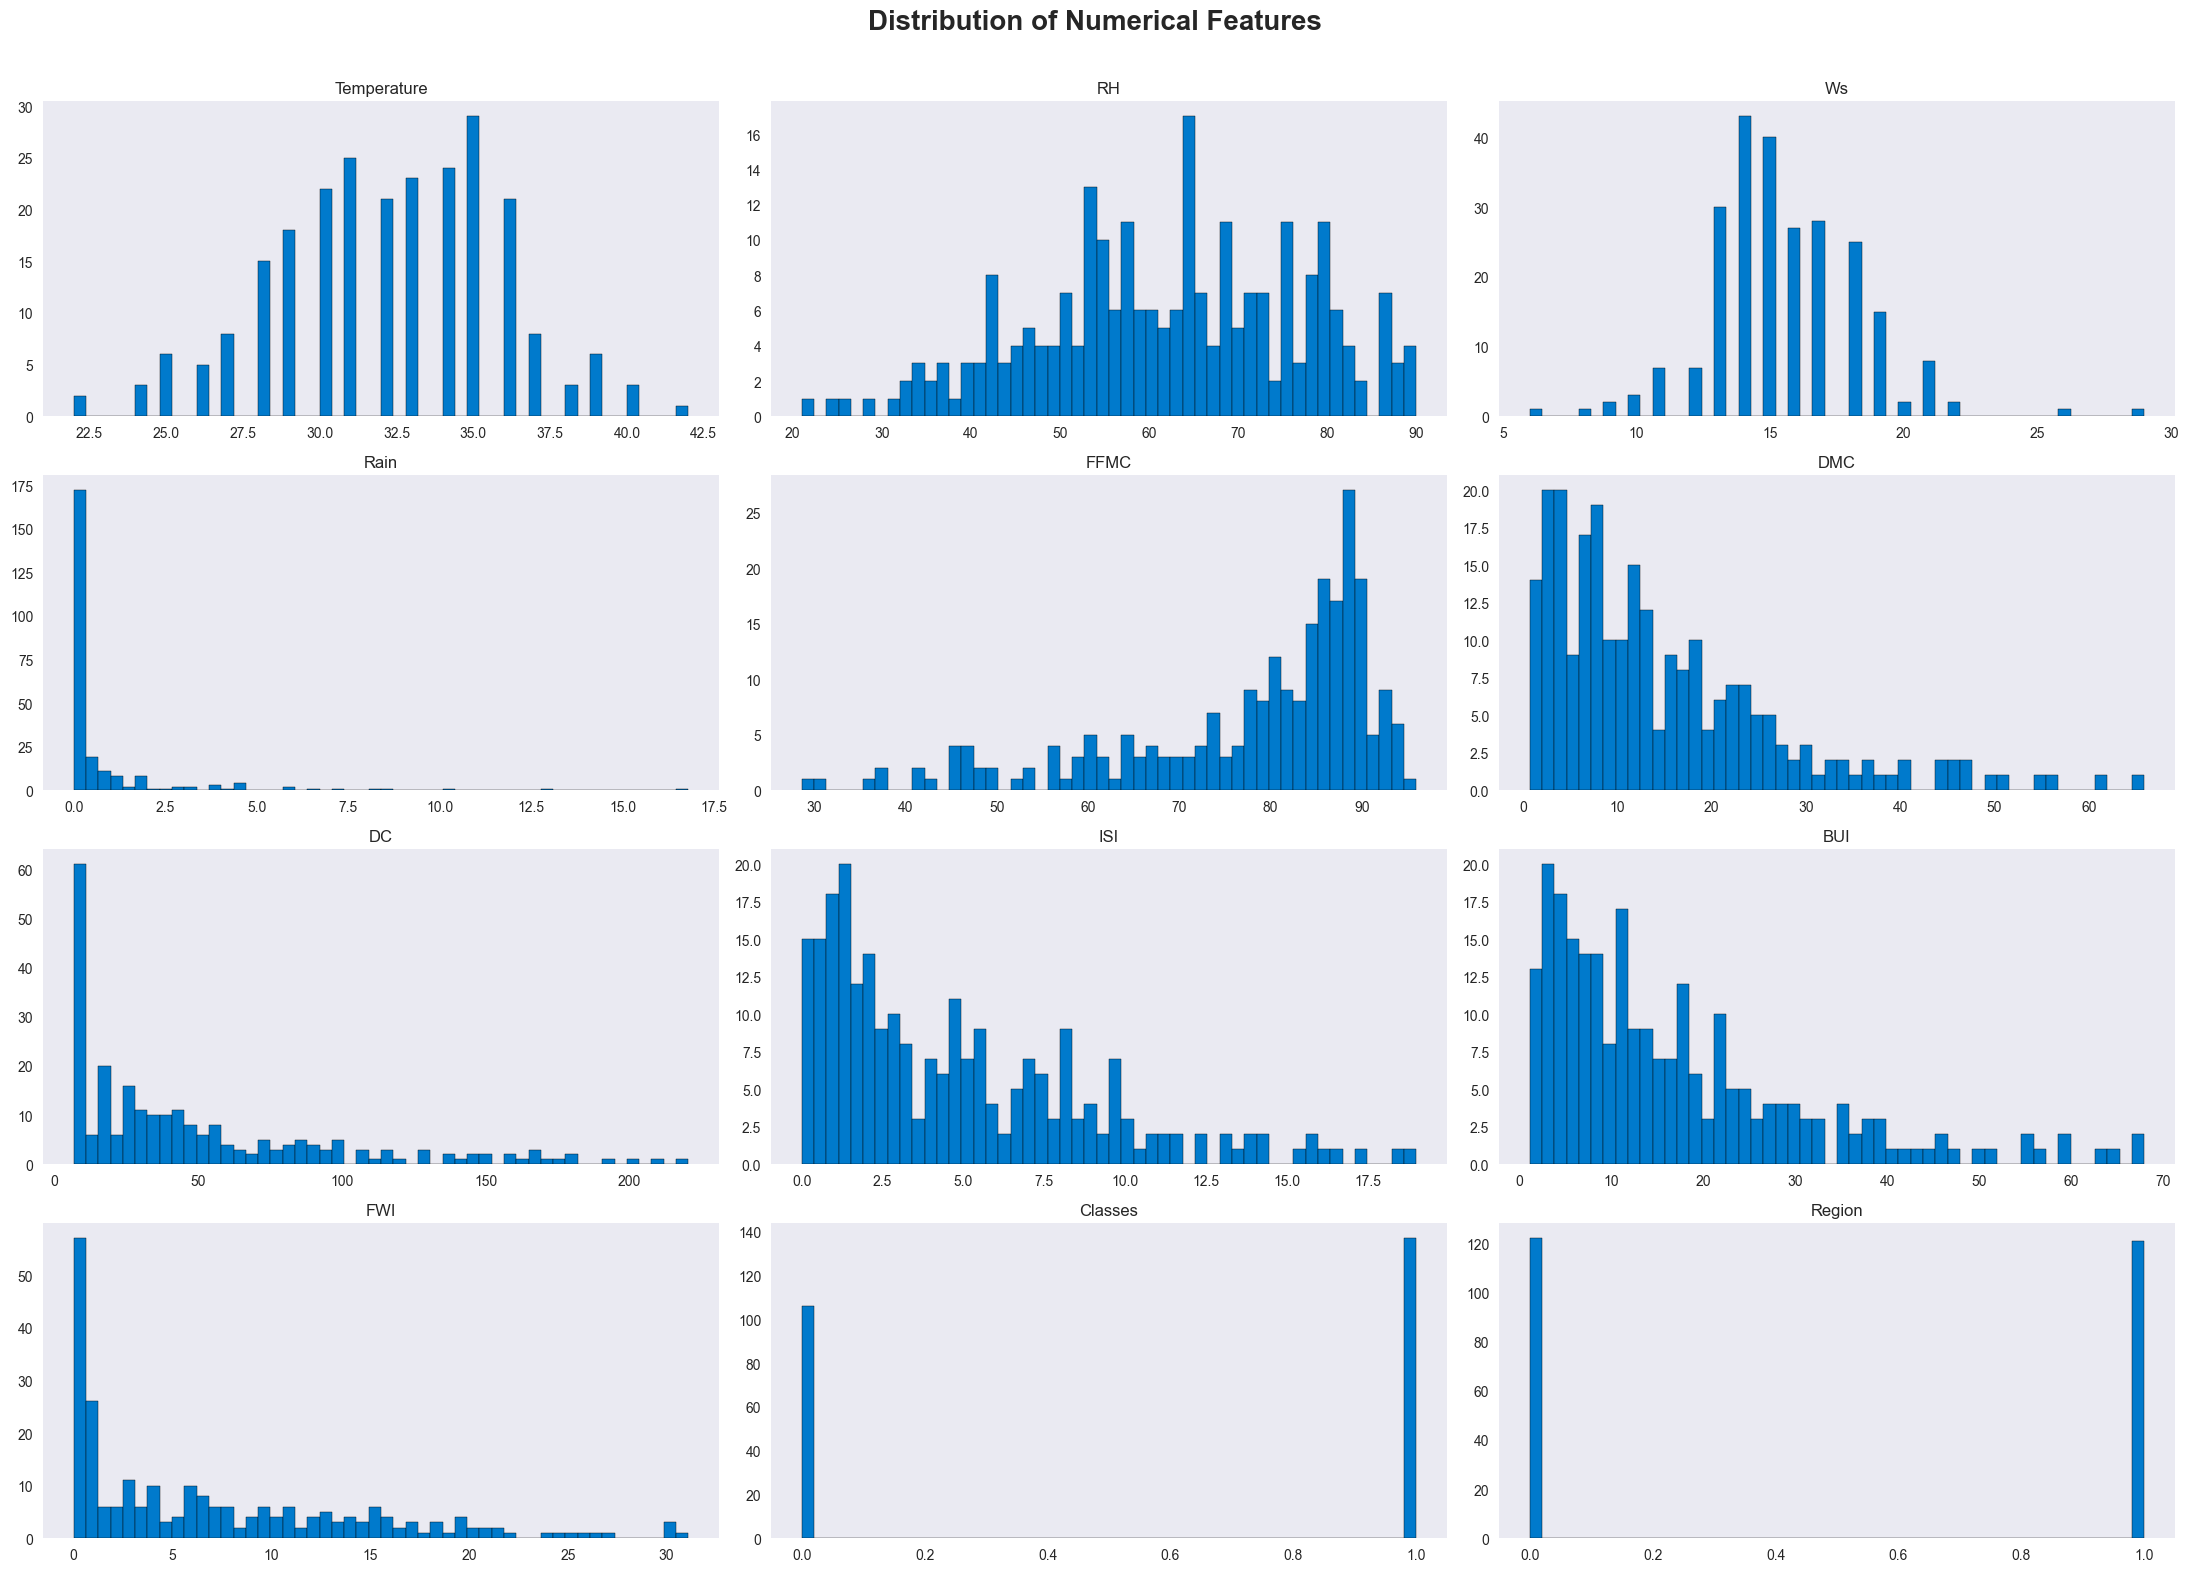

In [22]:
# ------------------------------------------------------------------------------------------------------
# Plot histogram (density distribution) for all numerical features
# ------------------------------------------------------------------------------------------------------
# Before training a regression model, it is important to understand the distribution of each feature.
# Histograms help us observe:
#   • whether the feature is normally distributed or skewed
#   • presence of outliers or extreme values
#   • feature spread and range
#
# The seaborn-like plotting style provides a cleaner visual appearance with softer gridlines.
# `bins=50` ensures fine-grained visualization of the data distribution, while `figsize=(20, 15)`
# prevents overcrowding of subplots and makes each histogram easier to interpret.
#
# This plot gives a high-level overview of all variable distributions in a single visualization,
# supporting decisions such as:
#   • whether scaling/normalization is required
#   • whether log transformation might help (for highly skewed variables)
#   • whether to handle outliers before training
# ------------------------------------------------------------------------------------------------------
plt.style.use('seaborn-v0_8')
dataset_copy.hist(bins=50, figsize=(22, 16), color='#007acc', edgecolor='black', grid=False)
plt.suptitle('Distribution of Numerical Features', fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])  # adjust spacing to keep title visible
plt.show()


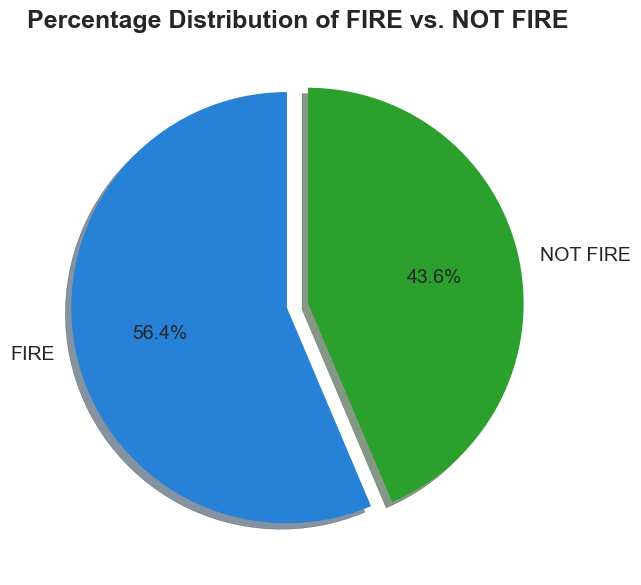

In [23]:
# ------------------------------------------------------------------------------------------------------
# Plot a Pie Chart showing the percentage distribution of fire vs. non-fire observations
# ------------------------------------------------------------------------------------------------------
# The 'Classes' column represents whether a fire event occurred (1) or not (0). Visualizing the
# distribution of these categories helps us quickly understand class balance in the dataset.
#
# `value_counts(normalize=True)` returns relative frequencies instead of raw counts.
# Multiplying by 100 converts them into percentages, making the chart easier to interpret.
#
# Class balance analysis is important because:
#   • ML models may become biased if one class dominates the dataset
#   • imbalance can negatively affect evaluation metrics such as accuracy and recall
#   • resampling strategies (oversampling/undersampling) may be required if imbalance is high
# ------------------------------------------------------------------------------------------------------
percentange_of_fire = dataset_copy['Classes'].value_counts(normalize=True) * 100

# ------------------------------------------------------------------------------------------------------
# Visualization Enhancements
#   • Custom color palette used to distinguish fire vs. non-fire clearly
#   • `autopct` displays the exact percentage on each slice of the pie
#   • `startangle=90` rotates the chart for better readability
#   • `explode` visually separates the slices slightly to highlight categories
#   • `shadow=True` improves depth perception and aesthetic appeal
# ------------------------------------------------------------------------------------------------------
class_labels = ['FIRE', 'NOT FIRE']
colors = ["#2781d6", '#2ca02c']  # red = fire, green = not fire
explode = (0.05, 0.05)  # detach both slices slightly for visual clarity

plt.figure(figsize=(12, 7))
plt.pie(
    percentange_of_fire,
    labels=class_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 14}
)

# Title enhancement for readability and presentation
plt.title('Percentage Distribution of FIRE vs. NOT FIRE', fontsize=18, fontweight='bold')
plt.show()


In [24]:
# Find the correlation between all the numerical columns in the dataset
# ------------------------------------------------------------------------------------------------------
# Correlation tells us how strongly two features are related to each other.
#
# For example:
#   • If Temperature increases and FWI also increases → they have a strong positive correlation
#   • If RH (humidity) increases but FWI decreases → they have a negative correlation
#   • If a feature changes but FWI does not change → low or no correlation
#
# Why we calculate correlation:
#   • It helps us understand which weather factors have the biggest impact on FWI
#   • It shows which features move together and which move in opposite directions
#   • It helps decide which features are useful for building the prediction model
#
# The `corr()` function creates a correlation table where:
#   • values close to 1 → strong positive relationship
#   • values close to -1 → strong negative relationship
#   • values close to 0 → little or no relationship
#
# This is an important step before training the model so that we know which variables are actually
# related to the target (FWI) and which variables may not be useful.
# ------------------------------------------------------------------------------------------------------
dataset_copy.corr()


,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
Temperature,1.000000,-0.651400,-0.284510,-0.326492,0.676568,0.485687,0.376284,0.603871,0.459789,0.566670,0.516015,0.269555
RH,-0.651400,1.000000,0.244048,0.222356,-0.644873,-0.408519,-0.226941,-0.686667,-0.353841,-0.580957,-0.432161,-0.402682
Ws,-0.284510,0.244048,1.000000,0.171506,-0.166548,-0.000721,0.079135,0.008532,0.031438,0.032368,-0.069964,-0.181160
Rain,-0.326492,0.222356,0.171506,1.000000,-0.543906,-0.288773,-0.298023,-0.347484,-0.299852,-0.324422,-0.379097,-0.040013
FFMC,0.676568,-0.644873,-0.166548,-0.543906,1.000000,0.603608,0.507397,0.740007,0.592011,0.691132,0.769492,0.222241
DMC,0.485687,-0.408519,-0.000721,-0.288773,0.603608,1.000000,0.875925,0.680454,0.982248,0.875864,0.585658,0.192089
DC,0.376284,-0.226941,0.079135,-0.298023,0.507397,0.875925,1.000000,0.508643,0.941988,0.739521,0.511123,-0.078734
ISI,0.603871,-0.686667,0.008532,-0.347484,0.740007,0.680454,0.508643,1.000000,0.644093,0.922895,0.735197,0.263197
BUI,0.459789,-0.353841,0.031438,-0.299852,0.592011,0.982248,0.941988,0.644093,1.000000,0.857973,0.586639,0.089408
FWI,0.566670,-0.580957,0.032368,-0.324422,0.691132,0.875864,0.739521,0.922895,0.857973,1.000000,0.719216,0.197102


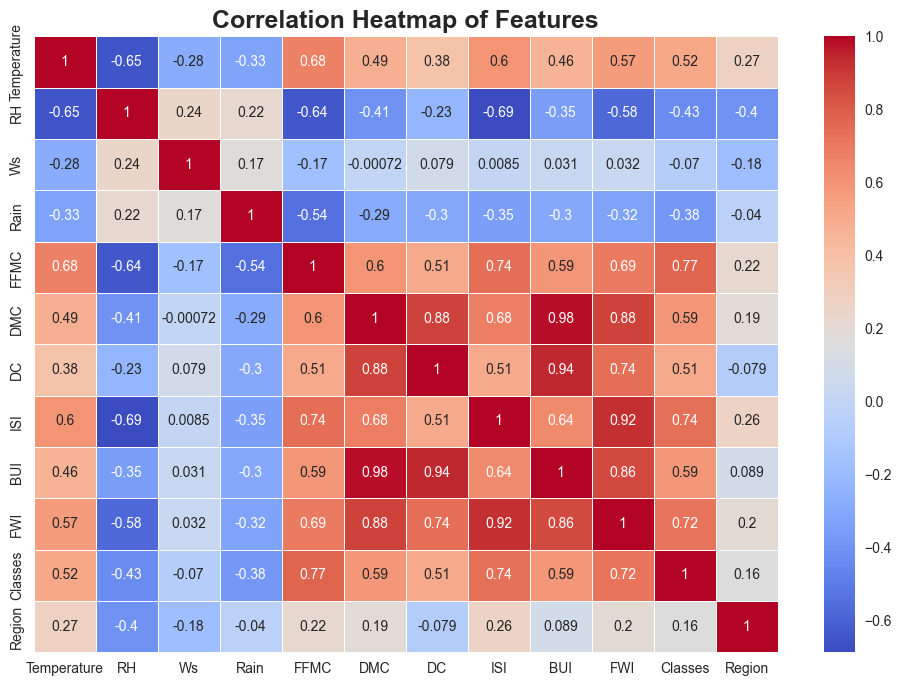

In [25]:
# ------------------------------------------------------------------------------------------------------
# Plot a heatmap to visualize the correlation between all numerical features
# ------------------------------------------------------------------------------------------------------
# The correlation table (corr()) gives numbers that show how strongly two features are related.
# But reading numbers in a big table can be confusing. A heatmap makes it easier to understand.
#
# What the heatmap shows:
#   • Each square represents the relationship between two features
#   • Dark red / bright colors → strong positive relationship (when one increases, the other increases)
#   • Dark blue / cool colors → strong negative relationship (when one increases, the other decreases)
#   • Light colors → little or no relationship
#
# Why this is useful:
#   • Helps us quickly see which features affect FWI the most
#   • Helps us detect features that provide the same information (highly correlated with each other)
#     — such features may not be needed together in the model
#   • Helps decide which features are important for prediction before training the machine learning model
#
# By visualizing correlations instead of reading raw numbers, we get a clear picture of how weather
# variables and fire risk are connected.
# ------------------------------------------------------------------------------------------------------
plt.figure(figsize=(12, 8))
sns.heatmap(dataset_copy.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features', fontsize=18, fontweight='bold')
plt.show()


🧠 Interpretation tip (simple)
- If FWI has high positive correlation with a feature → that feature is important for predicting fire severity
- If FWI has low or near-zero correlation → that feature may not be useful for prediction
- If two input features are highly correlated with each other → we might choose only one of them later to avoid redundancy

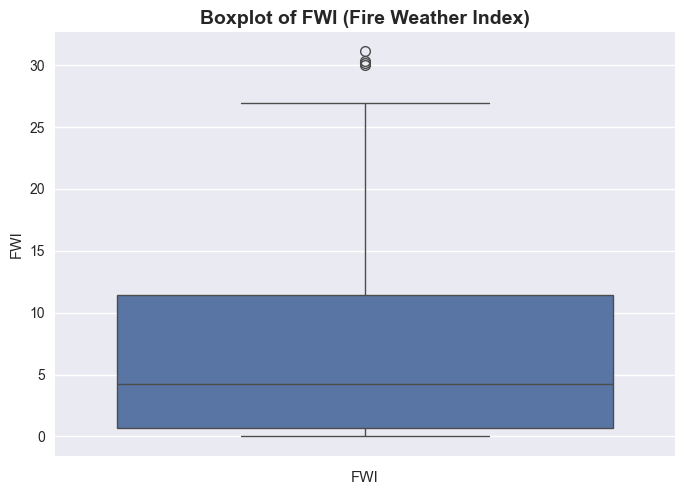

In [26]:
# Boxplot visualization for the target variable FWI
# ------------------------------------------------------------------------------------------------------
# Since FWI (Fire Weather Index) is our dependent variable — the value we want to predict using
# machine learning — it is very important to understand its distribution before building a model.
#
# A boxplot helps us quickly see:
#   • the typical range of FWI values (middle 50% of the data)
#   • the median (middle value)
#   • whether there are extreme values or outliers in the dataset
#
# Why this is useful for prediction:
#   • If FWI has many outliers (very high or very low values), some ML models may get biased
#   • If the distribution is very uneven, scaling or transformation might be required
#   • Understanding the spread of the target variable helps us pick the right regression algorithm
#
# So before training the model, we visualize the FWI boxplot to see if the target variable needs
# preprocessing such as outlier handling or normalization.
# ------------------------------------------------------------------------------------------------------
sns.boxplot(dataset_copy['FWI'])
plt.title('Boxplot of FWI (Fire Weather Index)', fontsize=14, fontweight='bold')
plt.xlabel('FWI')
plt.show()



---
## 📌 Interpretation of the Boxplot of FWI (Fire Weather Index)
The boxplot helps us understand how the Fire Weather Index (FWI) values are distributed in the dataset. Since FWI is our dependent (target) variable, examining its behavior is an important step before building a regression model.

---

### 🔍 What the different parts of the boxplot mean

| Component                           | Meaning                                                       |
| ----------------------------------- | ------------------------------------------------------------- |
| Lower boundary of the box           | 25% of data values are below this point                       |
| Middle line inside the box (median) | The central / typical FWI value                               |
| Upper boundary of the box           | 75% of data values are below this point                       |
| Whiskers (vertical lines)           | Normal range of FWI values excluding extreme points           |
| Outlier points (dots above whisker) | Unusually high FWI values compared to the rest of the dataset |

---

### 📌 What we observe from the graph

- Most FWI values lie in the range 0 to 12
- The median value is around 4, meaning half of the observations have FWI less than 4
- The distribution is positively skewed, meaning higher FWI values are rare but do occur
- A few outlier points above 30 indicate extreme fire weather conditions

---

### 🔥 Why this matters for machine learning

| Insight                  | Effect on modeling                                          |
| ------------------------ | ----------------------------------------------------------- |
| Presence of outliers     | Some regression models may get influenced by extreme values |
| Skewed distribution      | Normalization or transformation may help model performance  |
| Wide range of FWI values | Good for learning patterns in regression                    |

---

### 🧠 Simple summary

Most days have low fire danger, but occasionally the risk becomes very high, creating outliers. The model should learn what weather conditions cause these high FWI spikes.


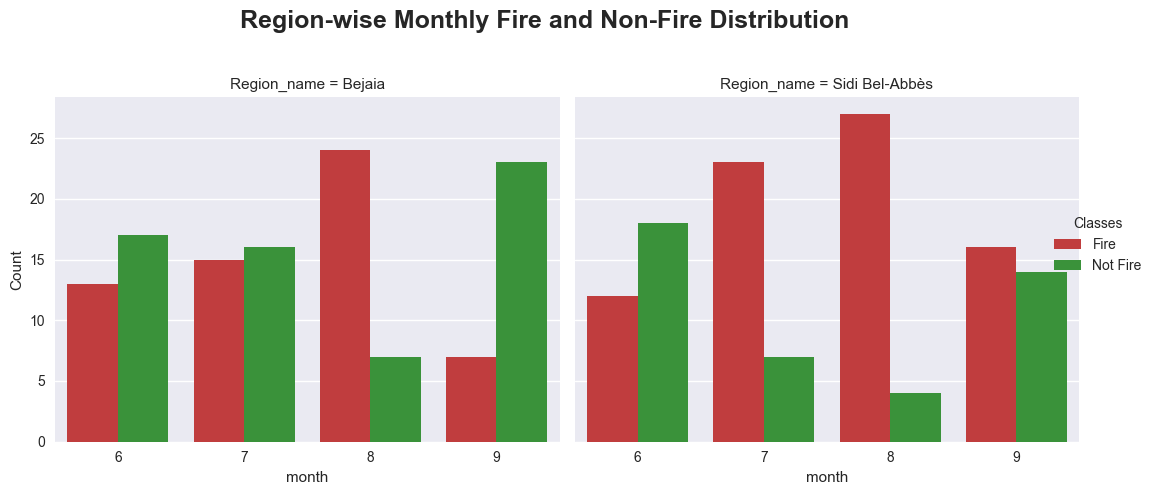

In [27]:
# ------------------------------------------------------------------------------------------------------
# Region-wise Monthly Fire and Non-Fire Analysis
# ------------------------------------------------------------------------------------------------------
# Goal of this visualization:
#   We want to understand how wildfire activity varies month-by-month across the two regions in the
#   dataset (Bejaia and Sidi Bel-Abbès), and how many of those observations correspond to
#   "Fire" vs "Not Fire" conditions. This comparison allows us to identify both seasonal and regional
#   differences in wildfire behavior.
#
# Step-by-step explanation:
#
# 1️⃣ Convert the 'Classes' column into readable labels ("Fire" / "Not Fire")
#     The original dataset stores fire status as text values ("fire" / "not fire"), and for clarity in
#     visualization we convert them into properly formatted class names. This step makes the legend and
#     plot more readable, especially for reporting and presentations.
#
# 2️⃣ Map the numeric Region codes (0 / 1) into human-readable region names
#     Although the dataset stores regions as numeric codes, numeric region labels do not convey meaning
#     during visualization. Mapping `0 → Bejaia` and `1 → Sidi Bel-Abbès` helps interpret the results
#     clearly without referring back to dataset documentation.
#
# 3️⃣ Group the dataset by Month × Region × Class (Fire / Not Fire)
#     This grouping allows us to count how many fire and non-fire cases occurred in each month for
#     each region. These counts become the values shown in the bar chart, allowing a side-by-side
#     comparison of both regions and classes.
#
# 4️⃣ Use a Seaborn `catplot` to generate two subplots — one for each region
#     Using `col='Region_name'`, we draw separate bar charts side-by-side for the two regions.
#     Each month contains two bars (Fire vs Not Fire), which allows easy comparison of:
#       • seasonal patterns within a region
#       • fire behavior differences between regions during the same month
#
# 5️⃣ Customize the legend position and format
#     By default, Seaborn draws the legend inside the plot area, which can overlap with bars and
#     obstruct interpretation. Moving the legend outside the figure provides a clean and professional
#     presentation without covering the chart elements.
#
# 6️⃣ Add a title and adjust layout
#     A descriptive plot title makes the visualization self-explanatory, and using `tight_layout()`
#     ensures that the title, legend, and subplots do not overlap.
#
# Outcome and purpose of the visualization:
#     This chart gives us a clear picture of wildfire behavior across both regions over time.
#     It reveals:
#       • Which months experience the highest fire activity
#       • Whether seasonal fire trends are similar across both regions
#       • Whether one region faces systematically higher fire risk than the other
#
#     Insights from this step guide future predictive modeling, resource allocation, seasonal
#     fire-preparedness planning, and further feature engineering.
# ------------------------------------------------------------------------------------------------------
# Count fire cases per region and per month using categorical region names
dataset['Classes'] = np.where(dataset['Classes'].str.contains('not fire'), 'Not Fire', 'Fire')
region_map = {0: 'Bejaia', 1: 'Sidi Bel-Abbès'}
dataset['Region_name'] = dataset['Region'].map(region_map)

# Group by month, Region_name and Classes (fire / not fire)
monthly_region_class = (
    dataset.groupby(['month', 'Region_name', 'Classes'], observed=True)
    .size()
    .reset_index(name='Count')
)


g = sns.catplot(
    data=monthly_region_class,
    x='month',
    y='Count',
    hue='Classes',
    col='Region_name',
    kind='bar',
    palette=['#d62728', '#2ca02c'],
    height=5,
    aspect=1
)

# Move legend outside, centered vertically
g._legend.set_title("Classes")
g._legend.set_bbox_to_anchor((1.05, 0.5))  # (x, y) → right side, center vertically

# Title using the new seaborn API
g.figure.suptitle('Region-wise Monthly Fire and Non-Fire Distribution', fontsize=18, fontweight='bold')

# Fix layout so the title and legend don't overlap
g.figure.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




---
## Feature Selection
---

In [28]:
display(dataset_copy.head())

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29.0,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0,0
1,29.0,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0,0
2,26.0,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0,0
3,25.0,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0,0
4,27.0,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0,0


In [29]:
# ------------------------------------------------------------------------------------------------------
# Split the dataset into independent (X) and dependent (y) variables
# ------------------------------------------------------------------------------------------------------
# In this project, our goal is to build a regression model that predicts the Fire Weather Index (FWI).
# Therefore:
#   • FWI is the value we want the model to learn and predict → this becomes the **dependent variable (y)**
#   • All the remaining features that help in predicting FWI (temperature, humidity, wind speed,
#     drought indices, etc.) become the **independent variables (X)**
#
# Why this separation is important:
#   • Machine learning algorithms require the input features (X) and the target output (y) as
#     separate objects
#   • It allows us to train the model on X while evaluating how accurately it predicts y
#
# By dropping only the 'FWI' column from X and keeping it separately in y, we clearly define what
# the model should learn from and what it should predict.
# ------------------------------------------------------------------------------------------------------
X = dataset_copy.drop('FWI', axis=1)
y = dataset_copy['FWI']

from IPython.display import Markdown

print(f"📌 Independent Features (X) — shape: {X.shape}")
print(f"Shape: {X.shape[0]} rows × {X.shape[1]} columns")
display(X.head())

print(f"🎯 Dependent Feature (y) — shape: {y.shape}")
print(f"Shape: {y.shape[0]} values")
display(y.head().to_frame())

📌 Independent Features (X) — shape: (243, 11)
Shape: 243 rows × 11 columns


,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,Classes,Region
0,29.0,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0,0
1,29.0,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0,0
2,26.0,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0,0
3,25.0,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0,0
4,27.0,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0,0


🎯 Dependent Feature (y) — shape: (243,)
Shape: 243 values


,FWI
0,0.5
1,0.4
2,0.1
3,0.0
4,0.5


In [30]:

from sklearn.model_selection import train_test_split

# ------------------------------------------------------------------------------------------------------
# Train–Test Split
# ------------------------------------------------------------------------------------------------------
# To evaluate how well our regression model can predict FWI (Fire Weather Index) on unseen data,
# we must divide the dataset into:
#   • Training set  → portion of the data used to train (fit) the model
#   • Test set      → portion of the data used to evaluate model performance
#
# train_test_split performs this separation automatically:
#   • X  → independent variables (features used for prediction)
#   • y  → dependent variable (FWI, the value we want to predict)
#
# Parameters used:
#   • test_size=0.25  
#         - 25% of the dataset is reserved for testing
#         - 75% is used for training the model
#         - This ensures enough data for learning while keeping sufficient data for unbiased evaluation
#
#   • random_state=42  
#         - Ensures the split is reproducible every time the code runs
#         - Without a fixed random_state, train/test samples would change on every run, leading to
#           inconsistent results and difficulty comparing models
#
# Why this step is important:
#   • It prevents the model from being evaluated on the same data it was trained on
#   • Ensures the performance score on the test set reflects real-world predictive ability
#   • Helps detect overfitting — if the model performs very well on training data but poorly on the
#     test set, it indicates the model is memorizing rather than learning patterns
# ------------------------------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


| Dataset part     | Used for                     |
| ---------------- | ---------------------------- |
| X_train, y_train | Training (fitting the model) |
| X_test, y_test   | Final performance evaluation |


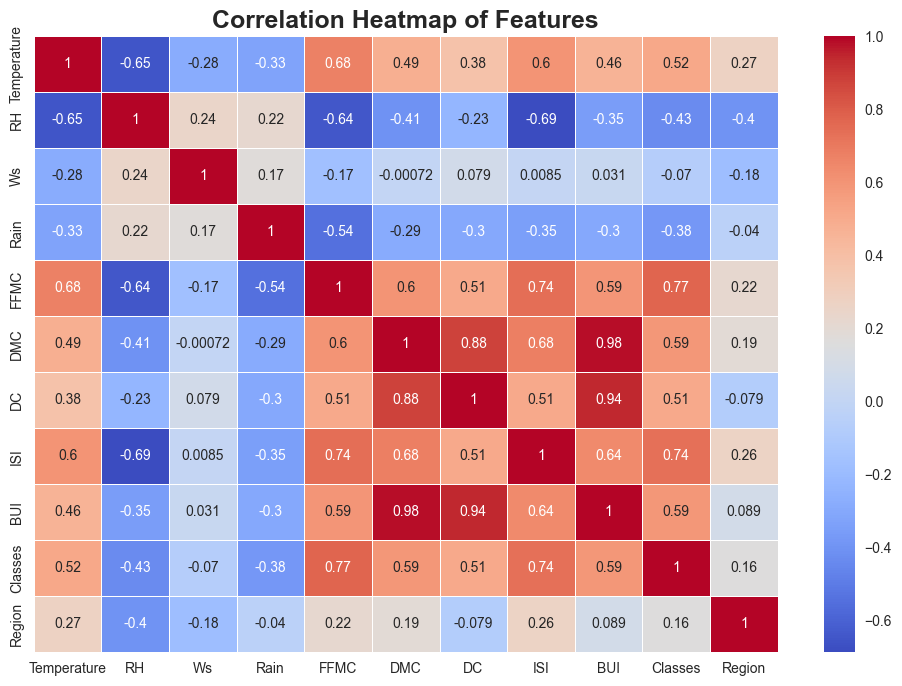

In [31]:
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features', fontsize=18, fontweight='bold')
plt.show()

In [32]:
## Feature selection based on correaltion 

## check for multicolinarlity 

def correlation(dataset, threshold):
    """
    Identify and return columns that show multicollinearity above a given threshold.
    
    This function detects pairs of features within a dataset that are highly correlated
    with each other. High correlation between independent variables (multicollinearity)
    can negatively affect regression models by:
        • Inflating coefficient variance
        • Reducing interpretability
        • Increasing model instability and overfitting
    Instead of checking correlation manually from a heatmap, this function automates
    the process by comparing each pair of features from the dataset's correlation matrix.

    Parameters
    ----------
    dataset : pandas.DataFrame
        The dataset containing only numerical features for correlation analysis.
        (Categorical columns should be encoded or excluded beforehand.)
    
    threshold : float
        The minimum absolute correlation value (e.g., 0.8) above which two
        features are considered to be multicollinear.

    Returns
    -------
    set
        A set of column names that are found to be highly correlated with other features.
        These columns may be considered as candidates for removal to reduce multicollinearity.
    
    Example
    -------
    >>> col_to_drop = correlation(dataset, 0.8)
    >>> print(col_to_drop)
    {'DMC', 'ISI', 'BUI'}
    """
    
    # Create an empty set to store the names of correlated columns
    # Using a set prevents duplicate entries (e.g., adding the same column multiple times)
    col_corr = set()
    
    # Generate the correlation matrix of the dataset (pairwise correlation values)
    corr_matrix = dataset.corr()
    
    # Loop through each column index in the correlation matrix
    for i in range(len(corr_matrix.columns)):
        
        # Loop only through previous columns to avoid repeating comparisons
        # (correlation matrix is symmetric: upper-right values = lower-left values)
        for j in range(i):
            
            # Check whether the absolute correlation between column i and column j
            # exceeds the specified threshold (e.g., > 0.8)
            if abs(corr_matrix.iloc[i, j]) > threshold:
                
                # If highly correlated, mark the current column for potential removal
                colname = corr_matrix.columns[i]
                col_corr.add(colname)

    # Return the set of column names that are highly correlated with another feature
    return col_corr


In [33]:
featues_mark_for_deletion = correlation(X_test, 0.90) # but this threshold is set by the domain expertise 

In [34]:
# ------------------------------------------------------------------------------------------------------
# Drop features with multicollinearity above the selected threshold
# ------------------------------------------------------------------------------------------------------
# After identifying the set of features (featues_mark_for_deletion) whose correlation with other
# independent variables exceeded the 90% threshold, we now remove them from the model inputs.
#
# Why this step is important:
#   • Highly correlated features provide duplicate information to the model
#   • This causes multicollinearity, which can:
#       - make regression coefficients unstable
#       - reduce model interpretability
#       - increase the risk of overfitting
#       - degrade generalization performance on unseen data
#
# Why we drop columns from both X_train and X_test:
#   • Machine learning models require that training and testing datasets contain the
#     exact same features in the exact same order
#   • If we drop columns only from X_train and not from X_test (or vice versa),
#     the model will throw an error because the input feature mismatch prevents prediction
#
# This step ensures that multicollinearity is handled consistently across both training
# and testing stages, leading to more stable and reliable regression model performance.
# ------------------------------------------------------------------------------------------------------
X_train.drop(featues_mark_for_deletion, axis=1, inplace=True)
X_test.drop(featues_mark_for_deletion, axis=1, inplace=True)

print(f"X_train {X_train.shape} ::: X_test {X_test.shape}")


X_train (182, 9) ::: X_test (61, 9)


In [35]:
# ------------------------------------------------------------------------------------------------------
# Feature Scaling using StandardScaler
# ------------------------------------------------------------------------------------------------------
# Many machine learning algorithms (especially distance-based and gradient-based models) perform
# better when numerical features are on the same scale, instead of having some values small (like 0–30)
# and others very large (like 0–3000).
#
# StandardScaler applies standardization to each feature:
#       z = (x − mean) / standard deviation
# After scaling:
#       • Each feature has mean ≈ 0
#       • Each feature has standard deviation ≈ 1
# This ensures that all features contribute equally during model training.
#
# Why `fit_transform` on X_train?
#   • `fit()` calculates scaling parameters — mean and standard deviation — from the training data
#   • `transform()` applies those learned scaling parameters to convert the data into scaled form
#   • Using `fit_transform()` together does both steps at once for the training dataset
#
# Why `transform` ONLY on X_test?
#   • The model must be evaluated on completely unseen data
#   • So we should NOT re-calculate scaling parameters on X_test (doing so would leak information)
#   • Instead, we **reuse the mean and standard deviation learned from X_train**
#   • This ensures the test data is scaled consistently and evaluation remains fair
#
# If we used fit_transform on both X_train and X_test separately:
#   × The test data would influence scaling statistics (data leakage)
#   × Model performance would look artificially better than it really is
#
# Final result:
#   • X_train_scaled → used for training
#   • X_test_scaled  → used for evaluation and prediction
# ------------------------------------------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # learn scaling from training data and apply it
X_test_scaled = scaler.transform(X_test)         # scale testing data using learned parameters only


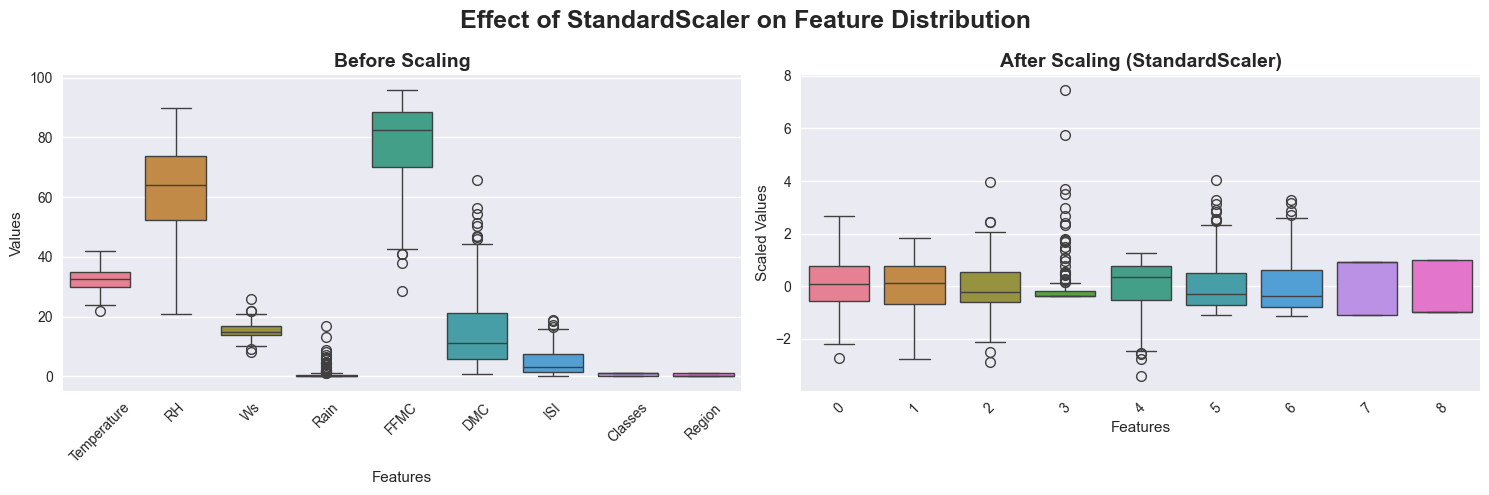

In [36]:
# ------------------------------------------------------------------------------------------------------
# Boxplots to visualize the effect of StandardScaler
# ------------------------------------------------------------------------------------------------------
# The purpose of this visualization is to compare the distribution of feature values before and after
# applying StandardScaler. Since the original dataset contains features measured on different scales
# (e.g., temperature in °C, wind speed, drought indices), the range of values is uneven and may cause
# some features to dominate the learning process.
#
# Why boxplots?
#   • Boxplots display the spread of data, median, quartiles, and outliers
#   • This makes them ideal for showing how scaling affects feature distributions
#
# What we expect from the visualization:
#   • BEFORE SCALING → Features have very different ranges and spreads
#   • AFTER SCALING  → All features should be centered around 0 with similar spread (std ≈ 1)
#
# Why this matters:
#   • StandardScaler ensures that all features contribute proportionally during model training
#   • It improves performance for distance-based and gradient-based algorithms
#   • It helps avoid bias toward features with large numeric ranges
#
# Final takeaway:
#   The boxplot comparison visually confirms whether scaling was applied correctly and whether the
#   transformed dataset is ready for machine learning.
# ------------------------------------------------------------------------------------------------------

plt.figure(figsize=(15, 5))

# Before scaling
plt.subplot(1, 2, 1)
sns.boxplot(data=X_train)
plt.title("Before Scaling", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.xlabel("Features")
plt.ylabel("Values")

# After scaling
plt.subplot(1, 2, 2)
sns.boxplot(data=X_train_scaled)
plt.title("After Scaling (StandardScaler)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.xlabel("Features")
plt.ylabel("Scaled Values")

plt.suptitle("Effect of StandardScaler on Feature Distribution", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()


## 📌 Interpretation of Boxplots — Effect of StandardScaler on Feature Distribution

The boxplots compare the feature values before and after applying StandardScaler. This visualization helps verify whether scaling has been applied correctly.

---

### 🔍 Before Scaling
- Each feature has a different numeric range and different units.
- Some features have very large values (e.g., FFMC, RH) while others are much smaller (e.g., Rain).
- Because of this imbalance, models may give more importance to features with larger absolute values even when they are not more important.

➡ In simple terms: the features were not on the same scale, so the model would not learn fairly.

---

### 🔍 After Scaling
- All features are centered around 0.
- All features have a similar spread (standard deviation close to 1).
- Outliers remain visible — scaling does not remove them, and that is normal.

➡ In simple terms: all features are now on the same scale, so the model will treat them equally.

---

### 🧠 Final Takeaway

| Before Scaling | After Scaling |
|---------------|---------------|
| Features have very different ranges | All features share a similar scale |
| Model becomes biased toward high-valued features | Model learns patterns fairly across all features |
| Not ideal for most ML algorithms | ✔ Ideal for regression and ML algorithms |

---

### 🚀 Why this matters
Scaling improves:
- Model accuracy
- Training stability
- Convergence speed
- Fair contribution from all features during learning


## 📌 Linear Regression Model — Training and Evaluation

This section builds, trains, and evaluates a Linear Regression model to predict the Fire Weather Index (FWI) based on the input features.

---

### 🔹 Model Training
A Linear Regression model is created and trained using the scaled training data:
- The model learns the relationship between the independent features (`X_train_scaled`)
  and the target variable (`y_train`)
- During training, the model attempts to identify the best-fitting line (or hyperplane)
  that minimizes the prediction error

Once the model is fitted, it is ready to make predictions on unseen data.

---

### 🔹 Model Prediction
The trained model is used to predict FWI values for the scaled test set (`X_test_scaled`).
These predicted values are compared against the actual FWI values (`y_test`)
to measure how accurately the model performs.

---

### 🔹 Performance Metrics

| Metric | What it tells us |
|--------|------------------|
| **MAE (Mean Absolute Error)** | Average size of errors, without considering direction |
| **MSE (Mean Squared Error)** | Penalizes large errors more strongly than MAE |
| **RMSE (Root Mean Squared Error)** | Error in the same unit as the target variable (more interpretable than MSE) |
| **R² Score** | Indicates how well the model explains variation in FWI (1 is perfect, 0 means no predictive power) |

Together, these metrics allow us to understand:
- How close the predictions are to actual FWI values
- Whether the model generalizes well to unseen data
- Whether further tuning or feature engineering is required

---

### 🧠 Final Takeaway
This step trains a Linear Regression model and evaluates it using widely accepted
regression metrics. The metric results help determine whether scaling, feature selection,
or using a more advanced model (e.g., Random Forest, XGBoost) is needed to improve prediction accuracy.


In [37]:
# ==========================
# Linear Regression model training and evaluation
# ==========================

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create an instance of the Linear Regression model
# This algorithm assumes a linear relationship between the input features and the target (FWI)
linear_regression_model = LinearRegression()

# Train (fit) the model on the scaled training features and target
# The model learns the best coefficients/weights that minimize prediction error on training data
linear_regression_model.fit(X_train_scaled, y_train)

# Predict FWI values for the scaled test data (unseen by the model during training)
# These predictions will later be compared with actual values to measure accuracy
y_pred = linear_regression_model.predict(X_test_scaled)

# ==========================
# Model Performance Metrics
# ==========================

# MSE (Mean Squared Error): Average of squared prediction errors
# Penalizes larger errors more heavily and helps understand model accuracy
mse = mean_squared_error(y_test, y_pred)

# MAE (Mean Absolute Error): Average size of prediction errors (absolute difference)
# Easy to interpret because it represents real error size in the original units of FWI
mae = mean_absolute_error(y_test, y_pred)

# RMSE (Root Mean Squared Error): Square root of MSE
# Gives error in the same scale as the target variable → easier to interpret than MSE
rmse = np.sqrt(mse)

# R² Score: Measures how much of the variance in FWI is explained by the model
# R² = 1 → perfect prediction, R² = 0 → no predictive power
r2 = r2_score(y_test, y_pred)

# Print model performance metrics for interpretation
print(f"R² Score: {r2:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")


R² Score: 0.9848
MSE : 0.6743
MAE : 0.5468
RMSE : 0.8211


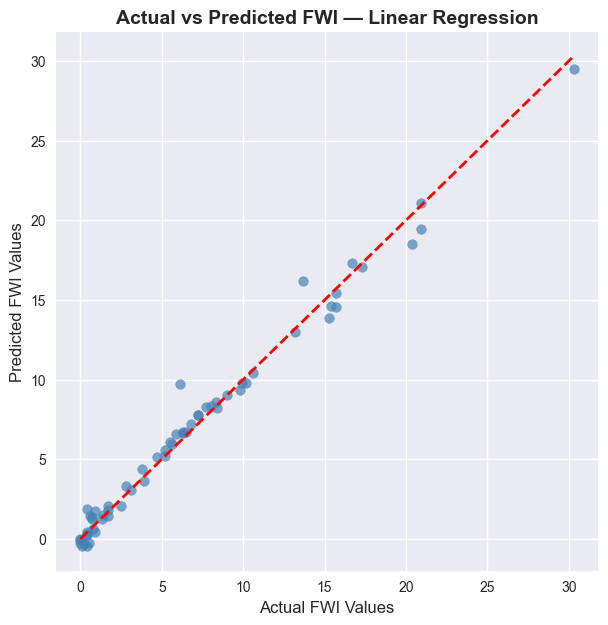

In [38]:
# Plot of Actual vs Predicted FWI values
plt.figure(figsize=(7, 7))

# Scatter plot comparing true FWI values vs model-predicted values
# Each point represents one sample in the test dataset
plt.scatter(y_test, y_pred, alpha=0.7, color='steelblue')

# Add a 45-degree reference line (y = x)
# This line represents perfect predictions — if the model predicted exactly right,
# all points would lie on this line
plt.plot(
    [y_test.min(), y_test.max()],     # x-coordinates range
    [y_test.min(), y_test.max()],     # y-coordinates range
    color='red', linestyle='--', linewidth=2
)

# Axis labels and title for readability
plt.xlabel("Actual FWI Values", fontsize=12)
plt.ylabel("Predicted FWI Values", fontsize=12)
plt.title("Actual vs Predicted FWI — Linear Regression", fontsize=14, fontweight='bold')

# Grid improves visibility of distance from the reference line
plt.grid(True)

# Display the scatter plot
plt.show()


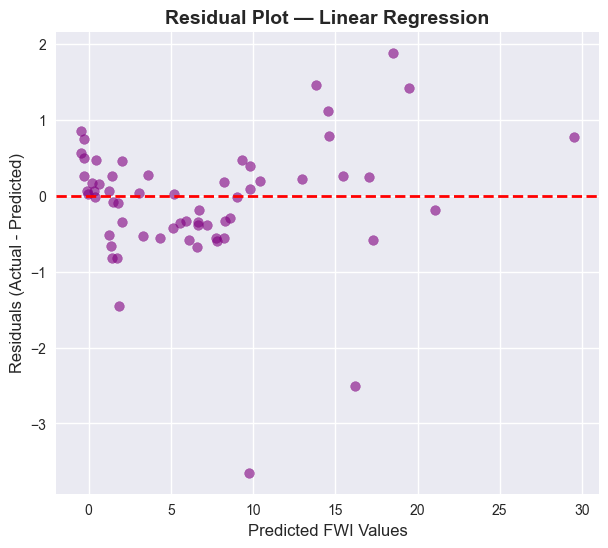

In [39]:
# ==========================================
# Residual Plot — to visualize prediction errors
# ==========================================

# Residual = Actual value − Predicted value
residuals = y_test - y_pred

plt.figure(figsize=(7, 6))

# Scatter plot of predicted values vs residuals
# Shows whether errors follow a random pattern (good) or pattern (bad)
plt.scatter(y_pred, residuals, color='purple', alpha=0.6)

# Reference line at zero residual
# If the model is unbiased, most residuals should be near this line
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.xlabel("Predicted FWI Values", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.title("Residual Plot — Linear Regression", fontsize=14, fontweight='bold')
plt.grid(True)
plt.show()


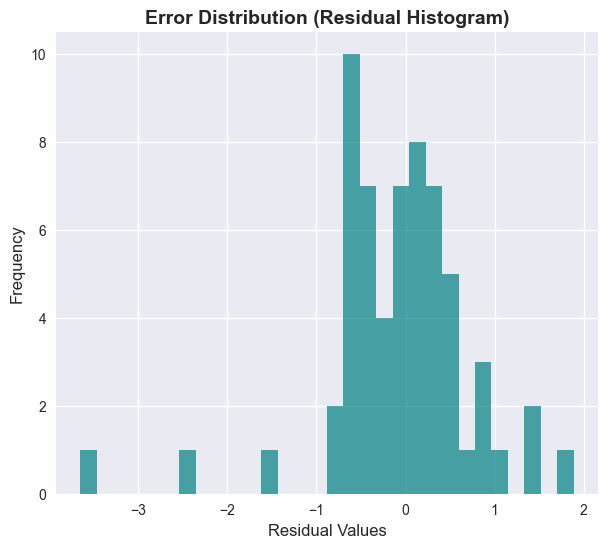

In [40]:
# ==========================================
# Error Distribution — to check normality of residuals
# ==========================================
plt.figure(figsize=(7, 6))

# Histogram of residuals — shows how errors are distributed
plt.hist(residuals, bins=30, color='teal', alpha=0.7)

plt.xlabel("Residual Values", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Error Distribution (Residual Histogram)", fontsize=14, fontweight='bold')
plt.grid(True)
plt.show()


## 📌 Interpretation of Residual Plot and Error Distribution Plot

### 🔹 Residual Plot (Actual − Predicted vs Predicted FWI)
- Each point shows how far a prediction is from the true value.
- The red dashed line represents **zero error** (perfect prediction).
- Most points are clustered around the red line, which means many predictions are reasonably accurate.
- However, some points are far away from the line, especially for higher predicted FWI values — this indicates **higher prediction error for large FWI values**.

➡ **Simple meaning:**  
The model is doing well for small and medium FWI values, but struggles to predict very high FWI values with the same accuracy.

---

### 🔹 Error Distribution Plot (Histogram of Residuals)
- The histogram shows how prediction errors (residuals) are distributed.
- Most errors are concentrated around zero → good sign.
- The distribution is not perfectly symmetric and shows a slight spread toward negative values.
- A few large negative residuals show cases where the model **under-predicted FWI by a large amount**.

➡ **Simple meaning:**  
Most predictions are close to the real values, but sometimes the model predicts much lower than it should — especially for high FWI values.

---

### 🧠 Final takeaway
| What the plots tell us | What it means for the model |
|------------------------|----------------------------|
| Errors mostly centered around zero | Model captures overall pattern |
| Some big residuals | Model makes large mistakes occasionally |
| Higher errors for high FWI values | Model might need a non-linear or more complex approach |

---

### 🚀 What’s next?

Since Linear Regression shows increasing error for high FWI values, we will now move to **regularized regression models**, which are more robust and handle multicollinearity and coefficient instability better than plain Linear Regression.

The next steps will be:

#### 🔹 Ridge Regression
- Adds **L2 regularization**
- Reduces coefficient magnitude but does not make them zero
- Useful when many features are moderately correlated
- Helps prevent overfitting

#### 🔹 Lasso Regression
- Adds **L1 regularization**
- Can shrink some coefficients all the way to **zero**
- Works as a regression model + automatic feature selection
- Useful when we want to identify the most impactful features

#### 🔹 ElasticNet Regression
- Combination of **L1 + L2 regularization**
- Useful when dataset has:
  - Many correlated features, and
  - We want both coefficient shrinkage and feature selection

---

### 🧠 Expected Benefits
| Model | Benefit |
|-------|---------|
| Ridge | Reduces overfitting and stabilizes coefficients |
| Lasso | Removes irrelevant features automatically |
| ElasticNet | Balances both Ridge and Lasso advantages |

---

### 🎯 Goal
To improve prediction accuracy — especially for **higher FWI values** — by using regularization to make the model more stable, generalizable, and less sensitive to noise.

---

Next step: begin with **Ridge Regression (with hyperparameter tuning for alpha)**.



---
## 🔍 Introduction to Lasso Regression

Lasso Regression (Least Absolute Shrinkage and Selection Operator) is an extension of Linear Regression that improves model performance and generalization by applying **L1 regularization**. In simple terms, Lasso adds a penalty to the regression equation that discourages large coefficients.

---

### 🧠 Why L1 Regularization?
The L1 penalty forces the model to shrink less-important feature coefficients toward zero. When the penalty is strong enough, some coefficients become **exactly zero**, which means Lasso effectively:
- reduces overfitting
- simplifies the model
- performs **automatic feature selection**

---

### 🎯 When to use Lasso
Lasso is especially useful when:
- there are many input features
- some features might not be relevant
- multicollinearity exists among features
- we want both a predictive model and feature importance insights

---

### 📌 Key advantages
| Benefit | Explanation |
|--------|-------------|
| Reduces overfitting | Shrinks large coefficients |
| Removes irrelevant features | Coefficients can become zero |
| Improves interpretability | Keeps only the most important predictors |

---

### ⚠ Note
Lasso may struggle when many features are strongly correlated — in that scenario, **ElasticNet** (combination of Lasso + Ridge) may perform better.

---

In summary, **Lasso Regression is a powerful regularized version of Linear Regression that improves accuracy and simplifies the model by selecting only the most meaningful features.**

---


In [41]:
from sklearn.linear_model import Lasso

# Create an instance of the Lasso Regression model
# Lasso applies L1 regularization — it penalizes large coefficients and can force some to become zero
# This helps reduce overfitting and also performs automatic feature selection
lasso_model = Lasso()

# Train the model using the scaled training data
# The algorithm learns regression coefficients while applying L1 penalty to control model complexity
lasso_model.fit(X_train_scaled, y_train)

# Predict FWI values for the test dataset
# These predictions will be compared with actual values to evaluate model performance
y_pred = lasso_model.predict(X_test_scaled)


# ==========================
# Model Performance Metrics
# ==========================

# MSE (Mean Squared Error): Average of squared prediction errors
# Penalizes larger errors more strongly — useful to understand how far predictions deviate from actual values
mse = mean_squared_error(y_test, y_pred)

# MAE (Mean Absolute Error): Average of absolute prediction errors
# Easier to interpret because it represents real error size in the original units of FWI
mae = mean_absolute_error(y_test, y_pred)

# RMSE (Root Mean Squared Error): Square root of MSE
# Gives error in the same scale as the target variable → more intuitive than MSE
rmse = np.sqrt(mse)

# R² Score: Indicates how well the model explains the variance in the target (FWI)
# R² = 1 → perfect model, 0 → no predictive power, negative → worse than baseline
r2 = r2_score(y_test, y_pred)

# Print model performance metrics for interpretation
print(f"R² Score: {r2:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")


R² Score: 0.9492
MSE : 2.2483
MAE : 1.1332
RMSE : 1.4994


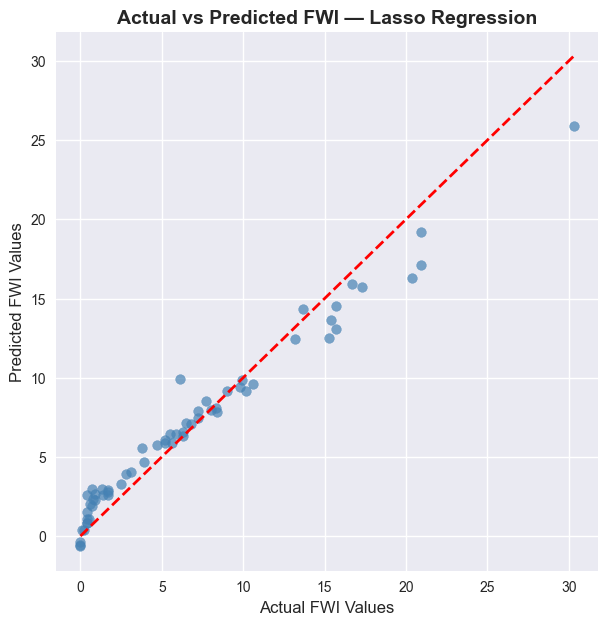

In [42]:
# Plot of Actual vs Predicted FWI values
plt.figure(figsize=(7, 7))

# Scatter plot comparing true FWI values vs model-predicted values
# Each point represents one sample in the test dataset
plt.scatter(y_test, y_pred, alpha=0.7, color='steelblue')

# Add a 45-degree reference line (y = x)
# This line represents perfect predictions — if the model predicted exactly right,
# all points would lie on this line
plt.plot(
    [y_test.min(), y_test.max()],     # x-coordinates range
    [y_test.min(), y_test.max()],     # y-coordinates range
    color='red', linestyle='--', linewidth=2
)

# Axis labels and title for readability
plt.xlabel("Actual FWI Values", fontsize=12)
plt.ylabel("Predicted FWI Values", fontsize=12)
plt.title("Actual vs Predicted FWI — Lasso Regression", fontsize=14, fontweight='bold')

# Grid improves visibility of distance from the reference line
plt.grid(True)

# Display the scatter plot
plt.show()


## 🔍 Introduction to Ridge Regression

Ridge Regression is an improved version of Linear Regression that uses **L2 regularization** to prevent overfitting. In the standard Linear Regression model, coefficients can become very large when features are highly correlated or when the dataset is noisy. Ridge overcomes this by adding a penalty that discourages excessively large coefficients.

### 🧠 Why L2 Regularization?
The L2 penalty forces the model to shrink large coefficients, making the model:
- more stable
- less sensitive to noise
- better at generalizing to unseen data

Unlike Lasso Regression, Ridge does **not** make coefficients exactly zero. Instead, it reduces them proportionally — making it effective when **all input features are useful** but need to be balanced.

### 📌 When to use Ridge
Ridge is especially effective when:
- multicollinearity exists among features
- many features contribute to the prediction
- we want to reduce overfitting without removing features

### ⚡ Key advantages

| Benefit | Explanation |
|--------|-------------|
| Reduces overfitting | Shrinks large coefficients |
| Stabilizes model | Handles correlated features well |
| Keeps all features | Does not eliminate predictors |

---

### 🧠 Final summary
Ridge Regression improves prediction quality by adding controlled regularization, making it a more reliable and generalizable version of Linear Regression — especially when the dataset has many correlated features.


In [43]:
from sklearn.linear_model import Ridge

# Create an instance of the Ridge Regression model
# Ridge applies L2 regularization — it penalizes large coefficients to reduce model complexity
# Unlike Lasso, Ridge does NOT set coefficients to zero but shrinks them to prevent overfitting
ridge_model = Ridge()

# Train (fit) the model on the scaled training data
# The model learns regression coefficients while applying L2 penalty to stabilize weights
ridge_model.fit(X_train_scaled, y_train)

# Predict FWI values for the test dataset
# These predictions will later be compared with the actual values to evaluate performance
y_pred = ridge_model.predict(X_test_scaled)

# ==========================
# Model Performance Metrics
# ==========================

# MSE (Mean Squared Error): Average squared difference between predicted and actual values
# Larger errors are penalized heavily → useful to measure prediction deviation
mse = mean_squared_error(y_test, y_pred)

# MAE (Mean Absolute Error): Average size of prediction errors (absolute differences)
# Very intuitive because it represents real error size in the original FWI units
mae = mean_absolute_error(y_test, y_pred)

# RMSE (Root Mean Squared Error): Square root of MSE
# Same unit as FWI, easier to understand than MSE — lower RMSE means better fit
rmse = np.sqrt(mse)

# R² Score: Indicates the proportion of variance in the target explained by the model
# 1 = perfect prediction, 0 = no predictive power, negative = worse than baseline model
r2 = r2_score(y_test, y_pred)

# Display model results
print(f"R² Score: {r2:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")


R² Score: 0.9843
MSE : 0.6949
MAE : 0.5642
RMSE : 0.8336


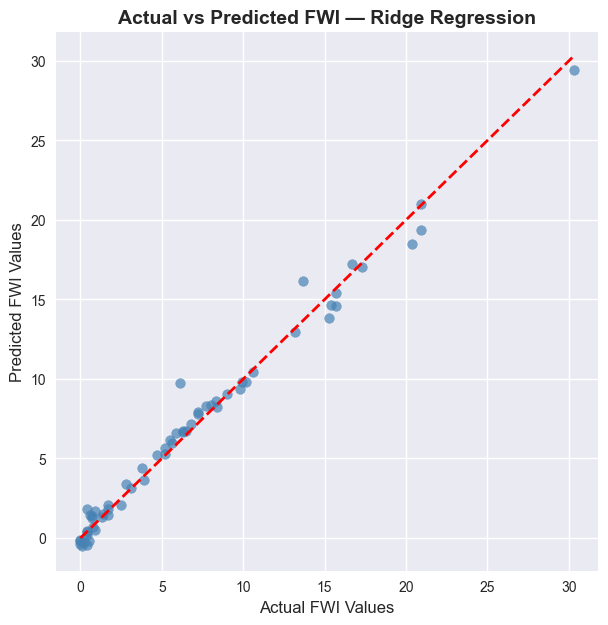

In [44]:
# Plot of Actual vs Predicted FWI values
plt.figure(figsize=(7, 7))

# Scatter plot comparing true FWI values vs model-predicted values
# Each point represents one sample in the test dataset
plt.scatter(y_test, y_pred, alpha=0.7, color='steelblue')

# Add a 45-degree reference line (y = x)
# This line represents perfect predictions — if the model predicted exactly right,
# all points would lie on this line
plt.plot(
    [y_test.min(), y_test.max()],     # x-coordinates range
    [y_test.min(), y_test.max()],     # y-coordinates range
    color='red', linestyle='--', linewidth=2
)

# Axis labels and title for readability
plt.xlabel("Actual FWI Values", fontsize=12)
plt.ylabel("Predicted FWI Values", fontsize=12)
plt.title("Actual vs Predicted FWI — Ridge Regression", fontsize=14, fontweight='bold')

# Grid improves visibility of distance from the reference line
plt.grid(True)

# Display the scatter plot
plt.show()


## 🔍 Introduction to ElasticNet Regression

ElasticNet Regression is a regularized version of Linear Regression that combines both **L1 regularization (Lasso)** and **L2 regularization (Ridge)**. It aims to maintain the benefits of both models by controlling model complexity while also performing feature selection.

### 🧠 Why ElasticNet?
- L1 (Lasso) helps reduce overfitting and can eliminate unimportant features by shrinking coefficients to zero.
- L2 (Ridge) stabilizes the model when features are highly correlated and prevents very large coefficients.
- ElasticNet mixes both effects, making it more reliable than using only Lasso or Ridge when the dataset has many correlated features.

### 🔧 Role of `l1_ratio`
| l1_ratio | Behavior |
|----------|----------|
| 1 | Works like Lasso |
| 0 | Works like Ridge |
| Between 0 and 1 | Blend of both |

### 📌 When to use ElasticNet
ElasticNet is especially useful when:
- The dataset contains many input features
- Some features are correlated with each other
- We want both **regularization + feature selection**

---

### 🧠 Final Summary
ElasticNet is a hybrid regularized regression model that balances the strengths of Ridge and Lasso. It reduces overfitting, stabilizes the model, and can remove irrelevant features — making it a powerful upgrade over standard Linear Regression for real-world datasets.


In [45]:
from sklearn.linear_model import ElasticNet

# Create an instance of ElasticNet Regression
# ElasticNet combines both L1 (Lasso) and L2 (Ridge) regularization
# l1_ratio controls the balance:
#   • l1_ratio = 1 → acts like Lasso
#   • l1_ratio = 0 → acts like Ridge
# Here l1_ratio = 0.5 means equal contribution from both L1 and L2 penalties
elasticnet_model = ElasticNet(l1_ratio=0.5)

# Train the model on the scaled training dataset
# The model learns regression coefficients while controlling complexity using both L1 & L2 penalties
elasticnet_model.fit(X_train_scaled, y_train)

# Predict FWI values for the test dataset
# These predictions will later be compared with actual values to evaluate model performance
y_pred = elasticnet_model.predict(X_test_scaled)

# ==========================
# Model Performance Metrics
# ==========================

# MSE (Mean Squared Error): Measures the average squared prediction error
# Penalizes large errors more strongly and indicates how far predictions deviate from real values
mse = mean_squared_error(y_test, y_pred)

# MAE (Mean Absolute Error): Measures the average size of prediction errors (absolute difference)
# Easy to interpret because it's in the same unit as the target variable (FWI)
mae = mean_absolute_error(y_test, y_pred)

# RMSE (Root Mean Squared Error): Square root of MSE
# More interpretable than MSE because it is in the original scale of FWI values
rmse = np.sqrt(mse)

# R² Score: Proportion of variance in the target variable explained by the model
# R² = 1 → perfect prediction, 0 → no predictive power
r2 = r2_score(y_test, y_pred)

# Display the performance results
print(f"R² Score: {r2:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")


R² Score: 0.8753
MSE : 5.5173
MAE : 1.8822
RMSE : 2.3489


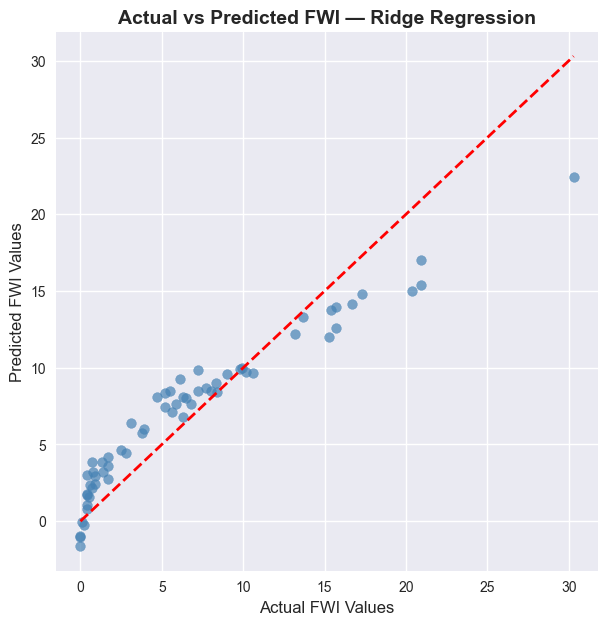

In [46]:
# Plot of Actual vs Predicted FWI values
plt.figure(figsize=(7, 7))

# Scatter plot comparing true FWI values vs model-predicted values
# Each point represents one sample in the test dataset
plt.scatter(y_test, y_pred, alpha=0.7, color='steelblue')

# Add a 45-degree reference line (y = x)
# This line represents perfect predictions — if the model predicted exactly right,
# all points would lie on this line
plt.plot(
    [y_test.min(), y_test.max()],     # x-coordinates range
    [y_test.min(), y_test.max()],     # y-coordinates range
    color='red', linestyle='--', linewidth=2
)

# Axis labels and title for readability
plt.xlabel("Actual FWI Values", fontsize=12)
plt.ylabel("Predicted FWI Values", fontsize=12)
plt.title("Actual vs Predicted FWI — Ridge Regression", fontsize=14, fontweight='bold')

# Grid improves visibility of distance from the reference line
plt.grid(True)

# Display the scatter plot
plt.show()


### 1️⃣ Ridge Regression with different alpha values

In [47]:
alphas = [0.01, 0.1, 1, 10, 100]

print("Ridge Regression: Effect of alpha on performance")
print("-" * 60)

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    y_pred = ridge.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"alpha = {alpha:<6} | R² = {r2:.4f} | RMSE = {rmse:.4f}")


Ridge Regression: Effect of alpha on performance
------------------------------------------------------------
alpha = 0.01   | R² = 0.9848 | RMSE = 0.8213
alpha = 0.1    | R² = 0.9847 | RMSE = 0.8223
alpha = 1      | R² = 0.9843 | RMSE = 0.8336
alpha = 10     | R² = 0.9771 | RMSE = 1.0076
alpha = 100    | R² = 0.8893 | RMSE = 2.2135


#### What this is doing
- alpha controls how strong the L2 penalty is:
    - small alpha → behaves closer to plain Linear Regression (less regularization)
    - large alpha → more shrinkage, simpler model, maybe underfitting
- We loop through several alpha values and see which one gives the best R² / lowest RMSE on your test set.

You’ll typically see something like:
- very small alpha → overfitting
- very large alpha → underfitting
- a sweet spot → good generalization

### 2️⃣ Lasso with alpha + max_iter

Lasso often needs a higher `max_iter` to converge, especially when features are scaled and many.

In [48]:
alphas = [0.0005, 0.001, 0.01, 0.1, 1]

print("\nLasso Regression: Effect of alpha on performance")
print("-" * 60)

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)  # increased max_iter for safety
    lasso.fit(X_train_scaled, y_train)
    y_pred = lasso.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # how many coefficients became zero? (feature selection effect)
    num_zero_coefs = np.sum(lasso.coef_ == 0)

    print(f"alpha = {alpha:<7} | R² = {r2:.4f} | RMSE = {rmse:.4f} | Zero Coefs = {num_zero_coefs}")



Lasso Regression: Effect of alpha on performance
------------------------------------------------------------
alpha = 0.0005  | R² = 0.9848 | RMSE = 0.8215 | Zero Coefs = 0
alpha = 0.001   | R² = 0.9847 | RMSE = 0.8218 | Zero Coefs = 0
alpha = 0.01    | R² = 0.9845 | RMSE = 0.8280 | Zero Coefs = 1
alpha = 0.1     | R² = 0.9783 | RMSE = 0.9795 | Zero Coefs = 4
alpha = 1       | R² = 0.9492 | RMSE = 1.4994 | Zero Coefs = 7


#### Why `max_iter` here?
- Lasso uses coordinate descent and sometimes doesn’t converge in 1000 iterations (default).
- `max_iter`=10000 gives it more time to converge and avoid warnings.
- If you see ConvergenceWarning, bump `max_iter` again.
#### Why tune alpha for Lasso?
- Small alpha → very little regularization, behaves closer to Linear Regression
- Larger alpha → more coefficients shrunk to zero → stronger feature selection
- Too large alpha → model becomes too simple, R² drops

### 3️⃣ ElasticNet practical example (alpha + l1_ratio)

In [49]:
alphas = [0.001, 0.01, 0.1, 1]
l1_ratios = [0.2, 0.5, 0.8]

print("\nElasticNet: Effect of alpha and l1_ratio on performance")
print("-" * 80)

for alpha in alphas:
    for l1 in l1_ratios:
        enet = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=10000)
        enet.fit(X_train_scaled, y_train)
        y_pred = enet.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        print(f"alpha = {alpha:<5} | l1_ratio = {l1:<3} | R² = {r2:.4f} | RMSE = {rmse:.4f}")



ElasticNet: Effect of alpha and l1_ratio on performance
--------------------------------------------------------------------------------
alpha = 0.001 | l1_ratio = 0.2 | R² = 0.9847 | RMSE = 0.8229
alpha = 0.001 | l1_ratio = 0.5 | R² = 0.9847 | RMSE = 0.8225
alpha = 0.001 | l1_ratio = 0.8 | R² = 0.9847 | RMSE = 0.8221
alpha = 0.01  | l1_ratio = 0.2 | R² = 0.9840 | RMSE = 0.8418
alpha = 0.01  | l1_ratio = 0.5 | R² = 0.9842 | RMSE = 0.8361
alpha = 0.01  | l1_ratio = 0.8 | R² = 0.9844 | RMSE = 0.8311
alpha = 0.1   | l1_ratio = 0.2 | R² = 0.9710 | RMSE = 1.1328
alpha = 0.1   | l1_ratio = 0.5 | R² = 0.9746 | RMSE = 1.0605
alpha = 0.1   | l1_ratio = 0.8 | R² = 0.9774 | RMSE = 1.0002
alpha = 1     | l1_ratio = 0.2 | R² = 0.8487 | RMSE = 2.5881
alpha = 1     | l1_ratio = 0.5 | R² = 0.8753 | RMSE = 2.3489
alpha = 1     | l1_ratio = 0.8 | R² = 0.9232 | RMSE = 1.8433


#### How to read this
- For each (`alpha`, `l1_ratio`) combo:
    - `alpha` = how strong the total regularization is
    - `l1_ratio` = how much of that is L1 vs L2
        - closer to 1 → more Lasso-like (more feature selection)
        - closer to 0 → more Ridge-like (more smooth shrinkage, fewer zeros)

You then pick the combo with best R² / RMSE.

## 🔍 Introduction to Cross-Validation (Hyper-parameter tuning)

Cross-validation is a technique used to evaluate how well a machine learning model will perform on unseen data.  
Instead of training and testing the model on just one split of the dataset, cross-validation splits the data into **multiple folds** and trains/tests the model multiple times.  
This helps us measure the model’s **true performance** and reduces the chances of **overfitting** or **lucky/unlucky train–test splits**.

### 🔹 Why Cross-Validation is useful
- Uses the dataset more efficiently
- Gives a more reliable estimate of model accuracy
- Helps select the best model and best hyperparameters
- Reduces risk of overfitting

---

## 🔧 Types of Cross-Validation specific to Regularized Regression

### 🔹 LassoCV
LassoCV applies **Lasso Regression (L1 regularization)** while automatically finding the best value of `alpha` using cross-validation.  
It not only reduces overfitting but also **selects the most important features** by shrinking some coefficients to zero.

### 🔹 RidgeCV
RidgeCV applies **Ridge Regression (L2 regularization)** and automatically chooses the best `alpha` based on cross-validation.  
It is useful when many features are correlated and we want to **stabilize coefficients without eliminating features**.

### 🔹 ElasticNetCV
ElasticNetCV combines **Lasso + Ridge (L1 + L2)** and uses cross-validation to tune both `alpha` and `l1_ratio`.  
It is helpful when:
- some features are correlated
- some features need to be reduced to zero
- we want both regularization and feature selection

---

### 🧠 Final takeaway
| Model | Regularization | Best for |
|--------|--------------|----------|
| LassoCV | L1 | Feature selection & removing irrelevant features |
| RidgeCV | L2 | Handling multicollinearity & stabilizing coefficients |
| ElasticNetCV | L1 + L2 | Balance between Ridge and Lasso (mixed benefits) |

Cross-validation makes these models more reliable by **automatically selecting the best hyperparameters** instead of depending on manual trial and error.


In [50]:
from sklearn.linear_model import LassoCV

# Create a LassoCV model
# LassoCV performs Lasso Regression (L1 regularization) and automatically selects
# the best value of alpha using cross-validation instead of manual trial and error.
# cv = 5 → 5-fold cross-validation (dataset is split into 5 parts and evaluated 5 times)
lassocv_model = LassoCV(cv=5)

# Train the model on the scaled training data
# During fitting, the model tries different alpha values and chooses the best one
lassocv_model.fit(X_train_scaled, y_train)

# Display the selected alpha value
# This is the alpha that produced the best cross-validation performance
print(f"Selected alpha by this model: {lassocv_model.alpha_} \n")

# Show all alpha values that were tested during cross-validation
print("List of alpha values tried by the model:")
print(lassocv_model.alphas_)
print()

# Show the MSE scores obtained during cross-validation for each alpha
# mse_path_ contains cross-validation errors across folds and helps understand
# how the model performance changed with different alpha values
print(f"Model performance on different alpha: \n {lassocv_model.mse_path_}")

# Predict FWI values for the test dataset using the trained model
y_pred = lassocv_model.predict(X_test_scaled)

# ==========================
# Model Performance Metrics
# ==========================

# MSE (Mean Squared Error): Measures average squared prediction error
# Penalizes larger deviations more strongly and indicates average error magnitude
mse = mean_squared_error(y_test, y_pred)

# MAE (Mean Absolute Error): Measures average absolute prediction error
# Easy to interpret because it represents the error in the same units as FWI
mae = mean_absolute_error(y_test, y_pred)

# RMSE (Root Mean Squared Error): Square root of MSE
# Same scale as FWI and easier to interpret than MSE — lower RMSE means better fit
rmse = np.sqrt(mse)

# R² Score: Proportion of variance in FWI explained by the model
# R² = 1 → perfect prediction, 0 → no predictive power
r2 = r2_score(y_test, y_pred)

# Display model performance results
print(f"R² Score: {r2:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")


Selected alpha by this model: 0.05725391318234405 

List of alpha values tried by the model:
[7.05853002 6.58280872 6.13914944 5.72539132 5.33951911 4.97965339
 4.64404142 4.33104857 4.03915039 3.76692517 3.51304702 3.27627941
 3.05546914 2.84954075 2.65749124 2.47838523 2.31135036 2.15557308
 2.01029467 1.87480753 1.74845178 1.63061198 1.52071419 1.41822315
 1.32263965 1.23349817 1.15036452 1.0728338  1.00052839 0.93309613
 0.87020857 0.81155943 0.75686304 0.705853   0.65828087 0.61391494
 0.57253913 0.53395191 0.49796534 0.46440414 0.43310486 0.40391504
 0.37669252 0.3513047  0.32762794 0.30554691 0.28495408 0.26574912
 0.24783852 0.23113504 0.21555731 0.20102947 0.18748075 0.17484518
 0.1630612  0.15207142 0.14182231 0.13226397 0.12334982 0.11503645
 0.10728338 0.10005284 0.09330961 0.08702086 0.08115594 0.0756863
 0.0705853  0.06582809 0.06139149 0.05725391 0.05339519 0.04979653
 0.04644041 0.04331049 0.0403915  0.03766925 0.03513047 0.03276279
 0.03055469 0.02849541 0.02657491 0.0

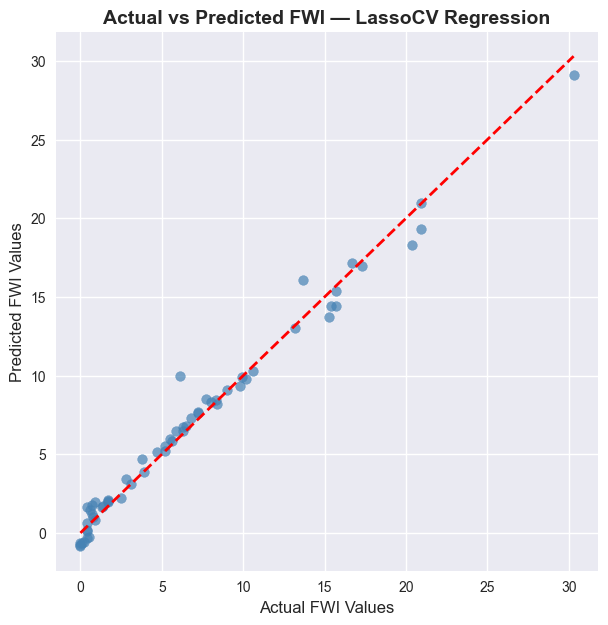

In [51]:
# Plot of Actual vs Predicted FWI values
plt.figure(figsize=(7, 7))

# Scatter plot comparing true FWI values vs model-predicted values
# Each point represents one sample in the test dataset
plt.scatter(y_test, y_pred, alpha=0.7, color='steelblue')

# Add a 45-degree reference line (y = x)
# This line represents perfect predictions — if the model predicted exactly right,
# all points would lie on this line
plt.plot(
    [y_test.min(), y_test.max()],     # x-coordinates range
    [y_test.min(), y_test.max()],     # y-coordinates range
    color='red', linestyle='--', linewidth=2
)

# Axis labels and title for readability
plt.xlabel("Actual FWI Values", fontsize=12)
plt.ylabel("Predicted FWI Values", fontsize=12)
plt.title("Actual vs Predicted FWI — LassoCV Regression", fontsize=14, fontweight='bold')

# Grid improves visibility of distance from the reference line
plt.grid(True)

# Display the scatter plot
plt.show()


In [52]:
from sklearn.linear_model import RidgeCV

# Create a RidgeCV model
# RidgeCV performs Ridge Regression (L2 regularization) and automatically selects
# the best value of alpha using cross-validation. Cross-validation ensures that the
# chosen alpha generalizes well and is not biased toward a single train-test split.
#
# cv = 5 → 5-fold cross-validation: the training dataset is split into 5 parts,
# and the model is trained and validated 5 times with different splits.
# (Note: If cv=None, RidgeCV defaults to Leave-One-Out cross-validation.)
ridgecv_model = RidgeCV(cv=5)

# Train the model on the scaled training data
# During training, the model evaluates multiple alpha values and picks the one
# that results in the lowest cross-validation error (best generalization performance)
ridgecv_model.fit(X_train_scaled, y_train)

# Display the selected alpha value — the most optimal based on cross-validation performance
print(f"Selected alpha by this model: {ridgecv_model.alpha_} \n")

# Display all alpha values that RidgeCV tested during cross-validation
# This list helps understand the search space used for hyperparameter tuning
print("List of alpha values tried by the model:")
print(ridgecv_model.alphas)
print()

# Predict FWI values for the test set using the trained model
# Final performance evaluation is always done using unseen (test) data
y_pred = ridgecv_model.predict(X_test_scaled)

# ==========================
# Model Performance Metrics
# ==========================

# MSE (Mean Squared Error): Measures the average squared difference
# between actual and predicted values. Highly penalizes large errors.
mse = mean_squared_error(y_test, y_pred)

# MAE (Mean Absolute Error): Measures the average size of the error
# (absolute differences) — easy to interpret in real-world units of FWI.
mae = mean_absolute_error(y_test, y_pred)

# RMSE (Root Mean Squared Error): Square root of MSE
# Same units as FWI, making interpretation more intuitive than MSE.
rmse = np.sqrt(mse)

# R² Score: Represents how much variance in the target is explained by the model.
# R² = 1 → perfect fit, 0 → model learns nothing useful.
r2 = r2_score(y_test, y_pred)

# Display performance results for interpretation
print(f"R² Score: {r2:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")


Selected alpha by this model: 1.0 

List of alpha values tried by the model:
(0.1, 1.0, 10.0)

R² Score: 0.9843
MSE : 0.6949
MAE : 0.5642
RMSE : 0.8336


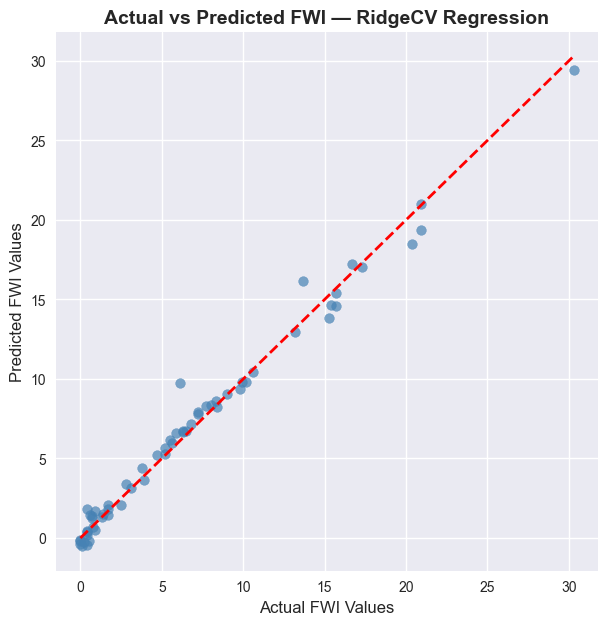

In [53]:
# Plot of Actual vs Predicted FWI values
plt.figure(figsize=(7, 7))

# Scatter plot comparing true FWI values vs model-predicted values
# Each point represents one sample in the test dataset
plt.scatter(y_test, y_pred, alpha=0.7, color='steelblue')

# Add a 45-degree reference line (y = x)
# This line represents perfect predictions — if the model predicted exactly right,
# all points would lie on this line
plt.plot(
    [y_test.min(), y_test.max()],     # x-coordinates range
    [y_test.min(), y_test.max()],     # y-coordinates range
    color='red', linestyle='--', linewidth=2
)

# Axis labels and title for readability
plt.xlabel("Actual FWI Values", fontsize=12)
plt.ylabel("Predicted FWI Values", fontsize=12)
plt.title("Actual vs Predicted FWI — RidgeCV Regression", fontsize=14, fontweight='bold')

# Grid improves visibility of distance from the reference line
plt.grid(True)

# Display the scatter plot
plt.show()


In [54]:
from sklearn.linear_model import ElasticNetCV

# ==========================================
# ElasticNetCV — L1 + L2 regularization with CV-based hyperparameter tuning
# ==========================================

# ElasticNetCV combines L1 (Lasso) and L2 (Ridge) regularization and automatically
# finds the best values of alpha and l1_ratio using cross-validation.
#
#   • l1_ratio controls the mix of L1 vs L2:
#       - 0   → pure Ridge (L2)
#       - 1   → pure Lasso (L1)
#       - between 0 and 1 → combination of both
#
# Here, we let ElasticNetCV try different l1_ratio values and multiple alpha values internally.
elasticnetcv_model = ElasticNetCV(
    l1_ratio=[0.2, 0.5, 0.8],  # different blends of L1/L2 to try
    cv=5,                      # 5-fold cross-validation
    max_iter=10000,            # extra iterations to ensure convergence
    n_jobs=-1                  # use all CPU cores (if available) to speed up CV
)

# Fit the ElasticNetCV model on the scaled training data
# During this process, it:
#   • tries different alpha and l1_ratio combinations
#   • evaluates them using 5-fold cross-validation
#   • picks the combination with the best average performance
elasticnetcv_model.fit(X_train_scaled, y_train)

# Display the selected best alpha and l1_ratio values
print(f"Best alpha selected by ElasticNetCV: {elasticnetcv_model.alpha_}")
print(f"Best l1_ratio selected by ElasticNetCV: {elasticnetcv_model.l1_ratio_}\n")

# Show all alpha values that were tested
print("List of alpha values tried by ElasticNetCV:")
print(elasticnetcv_model.alphas_)
print()

# (Optional) Show MSE path across folds for each alpha/l1_ratio combination
# This is more detailed and often used for analysis/debugging, not always printed in final notebook.
# print("MSE path shape (l1_ratio × alpha × folds):", elasticnetcv_model.mse_path_.shape)

# Predict FWI values for the test dataset using the best-found ElasticNet model
y_pred = elasticnetcv_model.predict(X_test_scaled)

# ==========================
# Model Performance Metrics
# ==========================

# MSE (Mean Squared Error): Measures the average squared error between actual and predicted values
mse = mean_squared_error(y_test, y_pred)

# MAE (Mean Absolute Error): Measures the average absolute difference between actual and predicted values
mae = mean_absolute_error(y_test, y_pred)

# RMSE (Root Mean Squared Error): Square root of MSE, same unit as FWI, easier to interpret
rmse = np.sqrt(mse)

# R² Score: Proportion of variance in FWI explained by the model
r2 = r2_score(y_test, y_pred)

# Display final performance of ElasticNetCV on the test set
print(f"R² Score: {r2:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")


Best alpha selected by ElasticNetCV: 0.04311146156383888
Best l1_ratio selected by ElasticNetCV: 0.5

List of alpha values tried by ElasticNetCV:
[[3.52926501e+01 3.29140436e+01 3.06957472e+01 2.86269566e+01
  2.66975955e+01 2.48982669e+01 2.32202071e+01 2.16552428e+01
  2.01957520e+01 1.88346259e+01 1.75652351e+01 1.63813971e+01
  1.52773457e+01 1.42477038e+01 1.32874562e+01 1.23919261e+01
  1.15567518e+01 1.07778654e+01 1.00514733e+01 9.37403767e+00
  8.74225891e+00 8.15305992e+00 7.60357097e+00 7.09111573e+00
  6.61319826e+00 6.16749084e+00 5.75182259e+00 5.36416900e+00
  5.00264196e+00 4.66548064e+00 4.35104286e+00 4.05779713e+00
  3.78431519e+00 3.52926501e+00 3.29140436e+00 3.06957472e+00
  2.86269566e+00 2.66975955e+00 2.48982669e+00 2.32202071e+00
  2.16552428e+00 2.01957520e+00 1.88346259e+00 1.75652351e+00
  1.63813971e+00 1.52773457e+00 1.42477038e+00 1.32874562e+00
  1.23919261e+00 1.15567518e+00 1.07778654e+00 1.00514733e+00
  9.37403767e-01 8.74225891e-01 8.15305992e-01 7

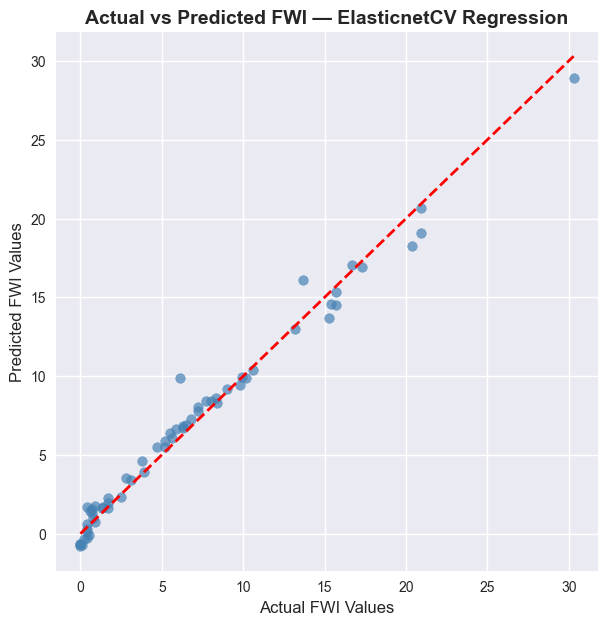

In [55]:
# Plot of Actual vs Predicted FWI values
plt.figure(figsize=(7, 7))

# Scatter plot comparing true FWI values vs model-predicted values
# Each point represents one sample in the test dataset
plt.scatter(y_test, y_pred, alpha=0.7, color='steelblue')

# Add a 45-degree reference line (y = x)
# This line represents perfect predictions — if the model predicted exactly right,
# all points would lie on this line
plt.plot(
    [y_test.min(), y_test.max()],     # x-coordinates range
    [y_test.min(), y_test.max()],     # y-coordinates range
    color='red', linestyle='--', linewidth=2
)

# Axis labels and title for readability
plt.xlabel("Actual FWI Values", fontsize=12)
plt.ylabel("Predicted FWI Values", fontsize=12)
plt.title("Actual vs Predicted FWI — ElasticnetCV Regression", fontsize=14, fontweight='bold')

# Grid improves visibility of distance from the reference line
plt.grid(True)

# Display the scatter plot
plt.show()


## Pickle the machine learning modles, preprocesssing model standard scaler

In [56]:
import pickle
pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(ridge_model, open('ridge_model.pkl', 'wb'))

In [ ]:
import joblib

# Save the fitted StandardScaler using joblib.
# joblib is efficient for serializing objects that contain large numpy arrays
# (like fitted transformers and models). The .joblib extension is conventional.
joblib.dump(scaler, "scaler.joblib")

# Save the trained Ridge regression model using joblib.
# Use joblib.load("ridge_model.joblib") later to restore the model for inference.
joblib.dump(ridge_model, "ridge_model.joblib")


['ridge_model.joblib']